# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Откройте файл с данными и изучите общую информацию. 

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

In [61]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data=pd.read_csv('C:/Users/dmitr/Jupiter_Notebook/datasets/Module_1/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### **Построю гистограммы для всех числовых столбцов таблицы:**

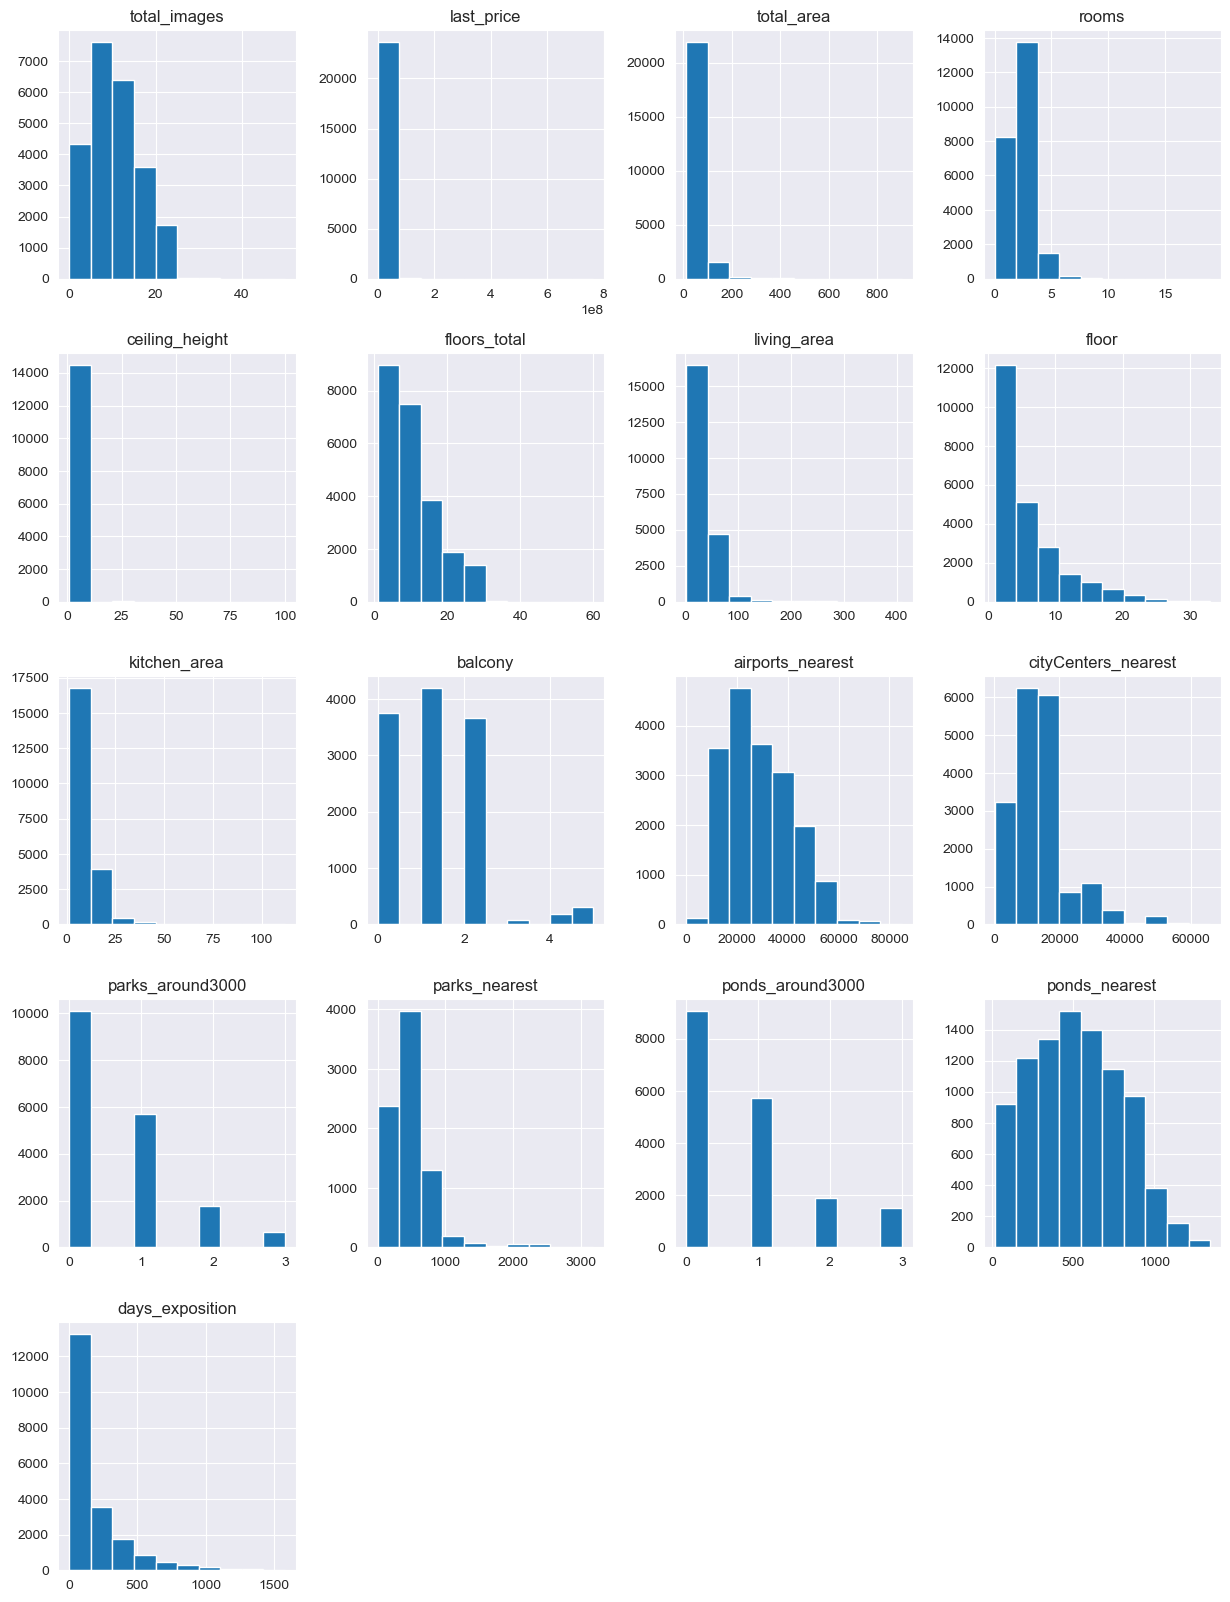

In [62]:
data.hist(figsize=(15,20));

### Предобработка данных

#### **Определяю в каких столбцах пропуски и, по возможности, их заполняю**

In [63]:
#Распечатаю количество пропусков для каждого столбца с пропусками
for i in data.columns:
    if data[i].isnull().sum():
        print(f'Passes for column "{i}": {data[i].isnull().sum()}')

Passes for column "ceiling_height": 9195
Passes for column "floors_total": 86
Passes for column "living_area": 1903
Passes for column "is_apartment": 20924
Passes for column "kitchen_area": 2278
Passes for column "balcony": 11519
Passes for column "locality_name": 49
Passes for column "airports_nearest": 5542
Passes for column "cityCenters_nearest": 5519
Passes for column "parks_around3000": 5518
Passes for column "parks_nearest": 15620
Passes for column "ponds_around3000": 5518
Passes for column "ponds_nearest": 14589
Passes for column "days_exposition": 3181


In [64]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

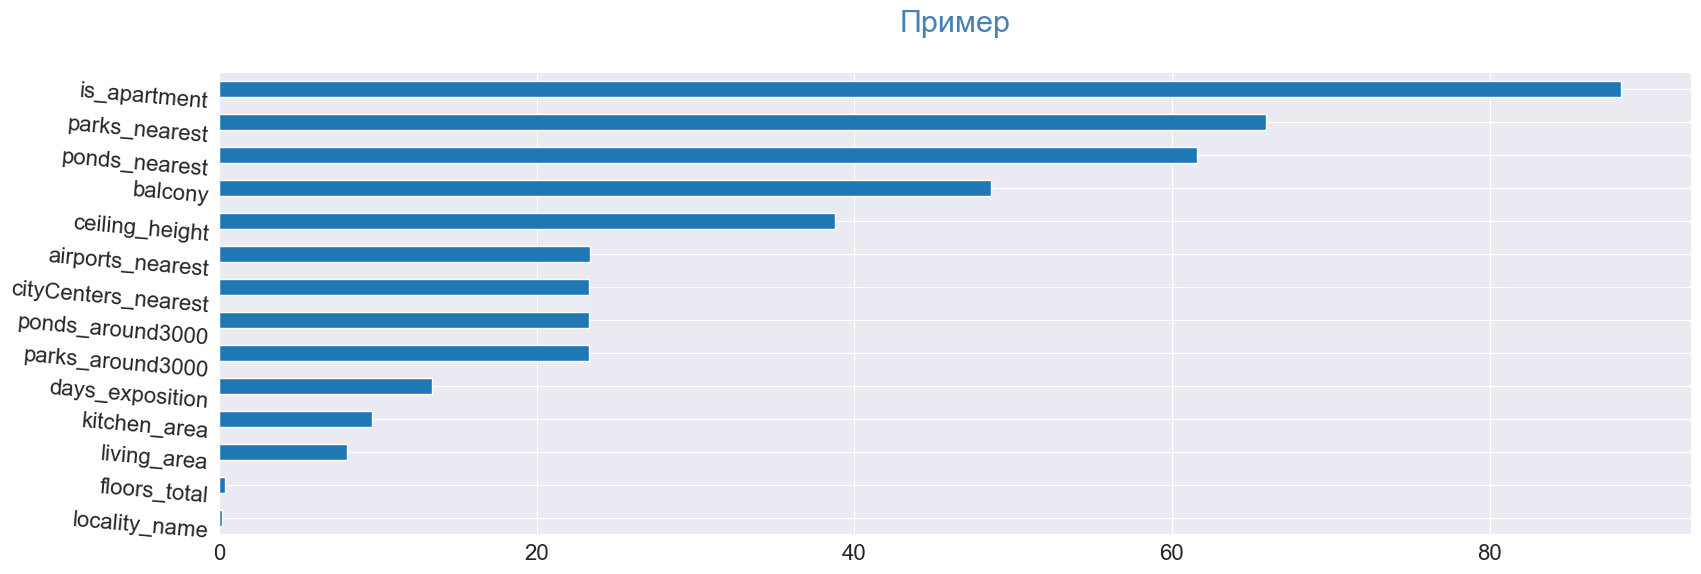

In [65]:
pass_value_barh(data)

In [66]:
#Здесь вспомагательные функции для заполнения пропусков

def fill_gaps(data,column,value):
    print(f'Количество пропусков для столбца "{column}": {data[column].isnull().sum()}')
    data[column] = data[column].fillna(value)
    print(f'Количество пропусков для столбца "{column}": {data[column].isnull().sum()}')


def fill_for_living_area(row):
    row['living_area'] = row['total_area'] * coeff1
    return row


def fill_for_kitchen_area(row):
    row['kitchen_area'] = row['total_area'] * coeff2
    return row


floors_total_median = data['floors_total'].median()
def fill_for_floors_total(row):
    row['floors_total'] = max(floors_total_median,row['floor'])
    return row


def cast_to_correct_value(row):
    correction = (row['living_area'] + row['kitchen_area'] - 0.9 * row['total_area']) / 2
    row['living_area'] -= correction
    row['kitchen_area'] -= correction
    return row

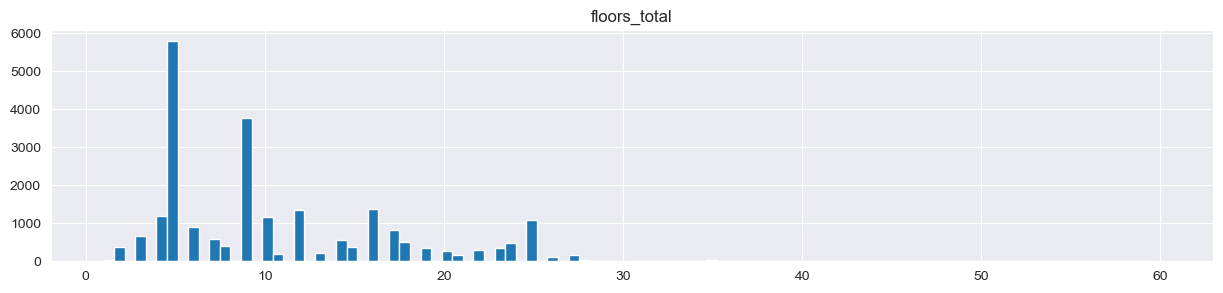

In [67]:
# check
data.hist(column = 'floors_total', bins = 100, figsize = (15,3));

In [68]:
# здесь заполняю медианой (не знаю, как связана (и связана ли вообще)
# высота потолков в квартирах с остальными столбцами в таблице)
column_name = 'ceiling_height'
column_median = data[column_name].median()
fill_gaps(data,column_name,column_median)


#здесь пропуски меняю на 0 (вероятнее всего заполняли люди и они, вероятно, оставили поле пустым, если балкона в их жилье нет)
column_name = 'balcony'
fill_gaps(data,column_name,0)


#заполню пропуски в "locality_name" "особым" значением, которое не встречается в этом столбце (например "unknown")
column_name = 'locality_name'
print(f'Количество пропусков для столбца "{column_name}": {data[column_name].isnull().sum()}')
if 'unknown' not in data['locality_name']:
    data.loc[data['locality_name'].isna(),'locality_name'] = 'unknown'
print(f'Количество пропусков для столбца "{column_name}": {data[column_name].isnull().sum()}')


column_name = 'airports_nearest'
#пока пропускаю (географические данные)


column_name = 'cityCenters_nearest'
#пока пропускаю (географические данные)


#здесь меняю на 0 (вероятнее всего заполняли люди и они, вероятно, оставили поле пустым, если парков рядом с их жильем нет)
column_name = 'parks_around3000'
fill_gaps(data,column_name,0)


column_name = 'parks_nearest'
# этот столбец пока пропускаю (пока непонятно, как заполнять пропуски, данных о ближайшем до дома парке нет)


#здесь меняю на 0 (вероятнее всего аполняли люди и они, вероятно, оставили поле пустым, если прудов рядом с их жильем нет)
column_name = 'ponds_around3000'
fill_gaps(data,column_name,0)


column_name = 'ponds_nearest'
# этот столбец тоже пока пропускаю (пока непонятно, как заполнять пропуски, данных о ближайшем до дома пруде нет)


# пока пропускаю (непонятно откуда (и, что более важно, когда) собирались данные для заполнения этого столбца)
column_name = 'days_exposition'

Количество пропусков для столбца "ceiling_height": 9195
Количество пропусков для столбца "ceiling_height": 0
Количество пропусков для столбца "balcony": 11519
Количество пропусков для столбца "balcony": 0
Количество пропусков для столбца "locality_name": 49
Количество пропусков для столбца "locality_name": 0
Количество пропусков для столбца "parks_around3000": 5518
Количество пропусков для столбца "parks_around3000": 0
Количество пропусков для столбца "ponds_around3000": 5518
Количество пропусков для столбца "ponds_around3000": 0


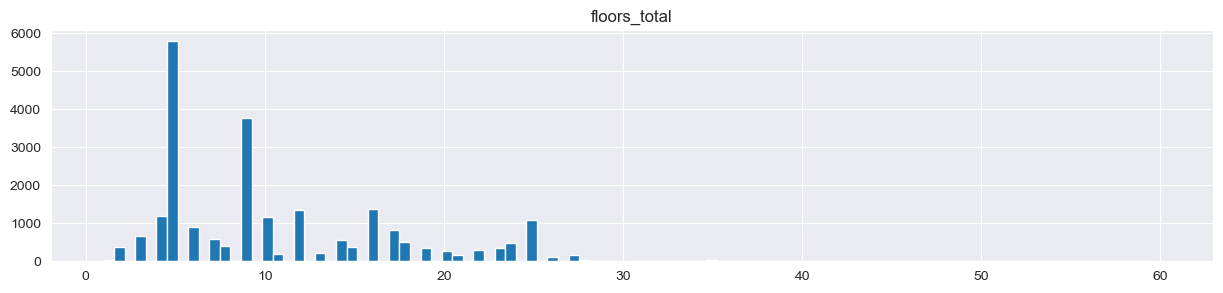

In [69]:
# check
data.hist(column = 'floors_total', bins = 100, figsize = (15,3));

##### **Причины появления пропусков в данных:**
1) Технологические проблемы (ошибка во время считывания/записи данных, следствие которой, например, возвращение из какой-нибудь функции значения None)

2) Человеческий фактор (пользователь забыл (или не захотел) заполнять какое-нибудь поле)

#### **Найду столбцы, в которых следует преобразовать тип данных и изменю в них тип данных**

In [70]:
# "last_price" можно заменить на int64
print(f'len(data[["last_price"]]): {len(data[["last_price"]])}')
print(f'len([i for i in data["last_price"] if (i-int(i))==0]): {len([i for i in data["last_price"] if (i-int(i))==0])}')


# "balcony" можно заменить на int64
print(f'len(data[["balcony"]]): {len(data[["balcony"]])}')
print(f'len([i for i in data["balcony"] if (i-int(i))==0]): {len([i for i in data["balcony"] if (i-int(i))==0])}')

# "parks_around3000" можно заменить на int64
print(f'len(data[["parks_around3000"]]): {len(data[["parks_around3000"]])}')
print(f'len([i for i in data["parks_around3000"] if (i-int(i))==0]): {len([i for i in data["parks_around3000"] if (i-int(i))==0])}')


# "ponds_around3000" можно заменить на int64
print(f'len(data[["ponds_around3000"]]): {len(data[["ponds_around3000"]])}')
print(f'len([i for i in data["ponds_around3000"] if (i-int(i))==0]): {len([i for i in data["ponds_around3000"] if (i-int(i))==0])}')


print('\n\nИзменяю тип данных...')
print('Старый тип данных:')
display(data[["last_price","first_day_exposition","balcony","parks_around3000","ponds_around3000"]].dtypes)
data = data.astype({"last_price":"int64","balcony":"int64","parks_around3000":"int64","ponds_around3000":"int64"})
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
print('Новый тип данных:\n')
display(data[["last_price","first_day_exposition","balcony","parks_around3000","ponds_around3000"]].dtypes)

len(data[["last_price"]]): 23699
len([i for i in data["last_price"] if (i-int(i))==0]): 23699
len(data[["balcony"]]): 23699
len([i for i in data["balcony"] if (i-int(i))==0]): 23699
len(data[["parks_around3000"]]): 23699
len([i for i in data["parks_around3000"] if (i-int(i))==0]): 23699
len(data[["ponds_around3000"]]): 23699
len([i for i in data["ponds_around3000"] if (i-int(i))==0]): 23699


Изменяю тип данных...
Старый тип данных:


last_price              float64
first_day_exposition     object
balcony                 float64
parks_around3000        float64
ponds_around3000        float64
dtype: object

Новый тип данных:



last_price                       int64
first_day_exposition    datetime64[ns]
balcony                          int64
parks_around3000                 int64
ponds_around3000                 int64
dtype: object

##### **Почему нужно изменить тип данных:**

1) Это упростит совершение необходимых операций над данными на основе их содержания (например, есть столбец со строками, каждая из которой представляет собой целое число -> необходимо изменить тип данных столбца с "object" на "int")

2) Это улучшит контроль за выполнением действий над данными (есть два столбца со строками, каждая из которой представляет собой целое число. Необходимо создать новый столбец который состоял бы из суммы значений первого и второго столбца. Если не изменить тип данных, можно получить не совсем желаемый результат)

#### **Устранение неявных дубликатов:**

In [71]:
first_template = 'поселок '
second_template = 'посёлок'
print(f'len(data["locality_name"]): {len(data["locality_name"].unique())}')
data['locality_name'] = data['locality_name'].replace(r'^[а-яё\s]*пос[её]лок[а-яё\s]*',first_template,regex=True)
print(f'len(data["locality_name"]): {len(data["locality_name"].unique())}')

len(data["locality_name"]): 365
len(data["locality_name"]): 319


#### **Устранение редких и выбивающихся значений**

Посмотрим в каких столбцах есть аномально высокие или аномально низкие значения

In [72]:
columns_with_outliers = ['total_images', 'last_price', 'total_area',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'kitchen_area',
       'days_exposition']
display(
    data[columns_with_outliers]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)
# display(
#     data[data.column]
#     .apply (['count', 'min', 'max'])   
#     .style.format("{:,.2f}")
# )

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,days_exposition
count,"23,699.00","23,699.00","23,699.00","23,699.00","23,699.00","23,613.00","21,796.00","23,699.00","21,421.00","20,518.00"
min,0.00,"12,190.00",12.00,0.00,1.00,1.00,2.00,1.00,1.30,1.00
max,50.00,"763,000,000.00",900.00,19.00,100.00,60.00,409.70,33.00,112.00,"1,580.00"


Дальше я удаляю редкие и выбивающиеся из общей картины значения для каждого столбца.

In [73]:
#Начинаю с столбца "last_price"
column_name = "last_price"

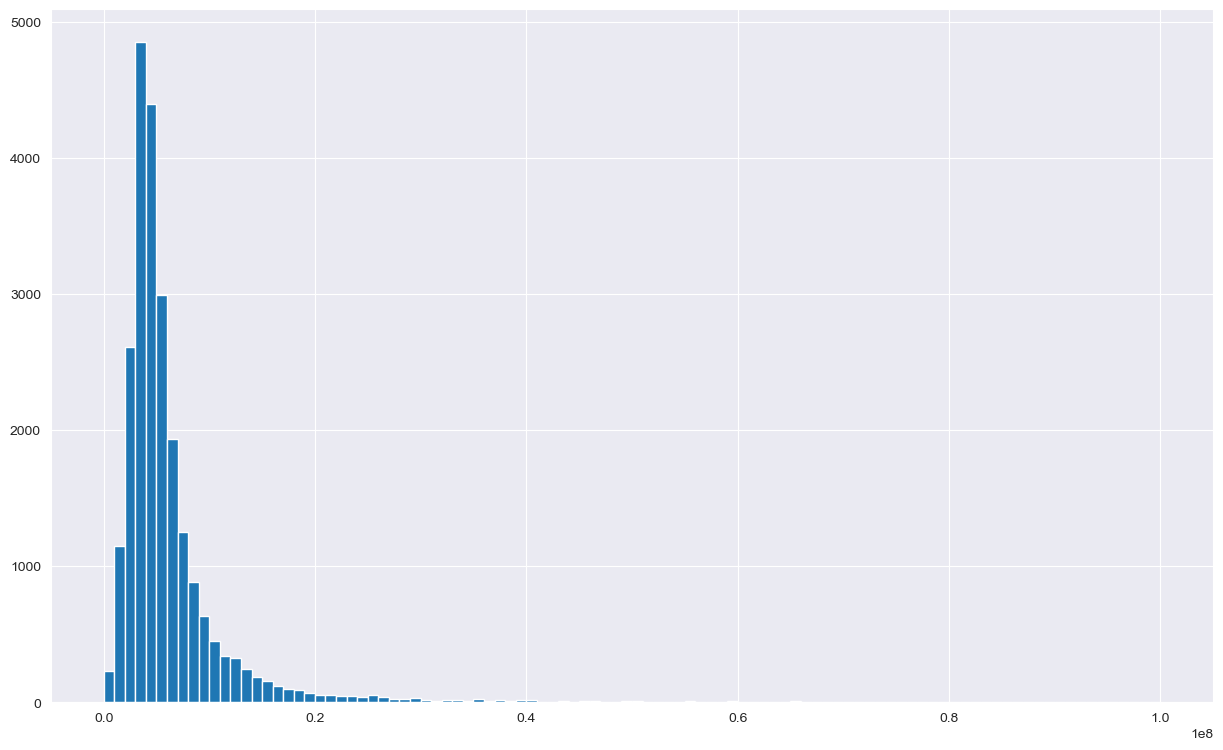

In [74]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,1e8));

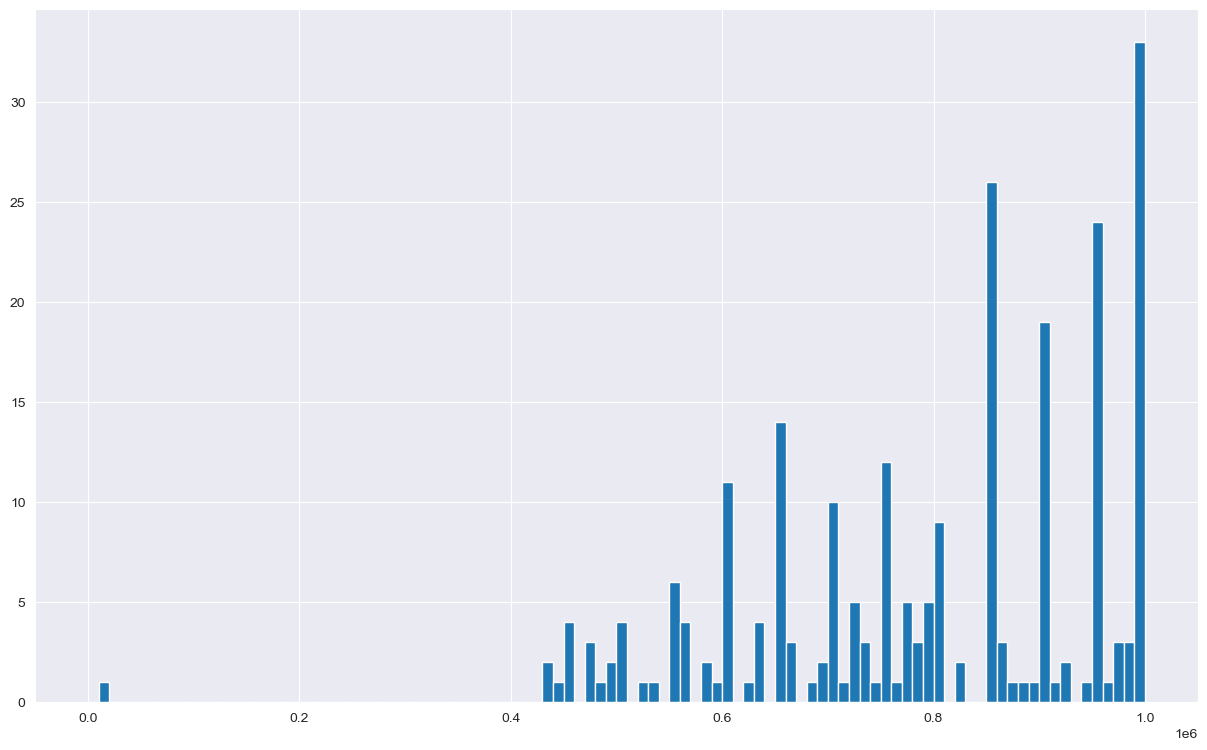

In [75]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,1e6));

In [76]:
result_range = (1e6,0.8*1e8)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) |
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["last_price"] > 80000000.0]): 59
len(data[data["last_price"] < 1000000.0]): 225
len(data): 23699
len(data): 23415


In [77]:
#Дальше столбец "total_area"
column_name = "total_area"

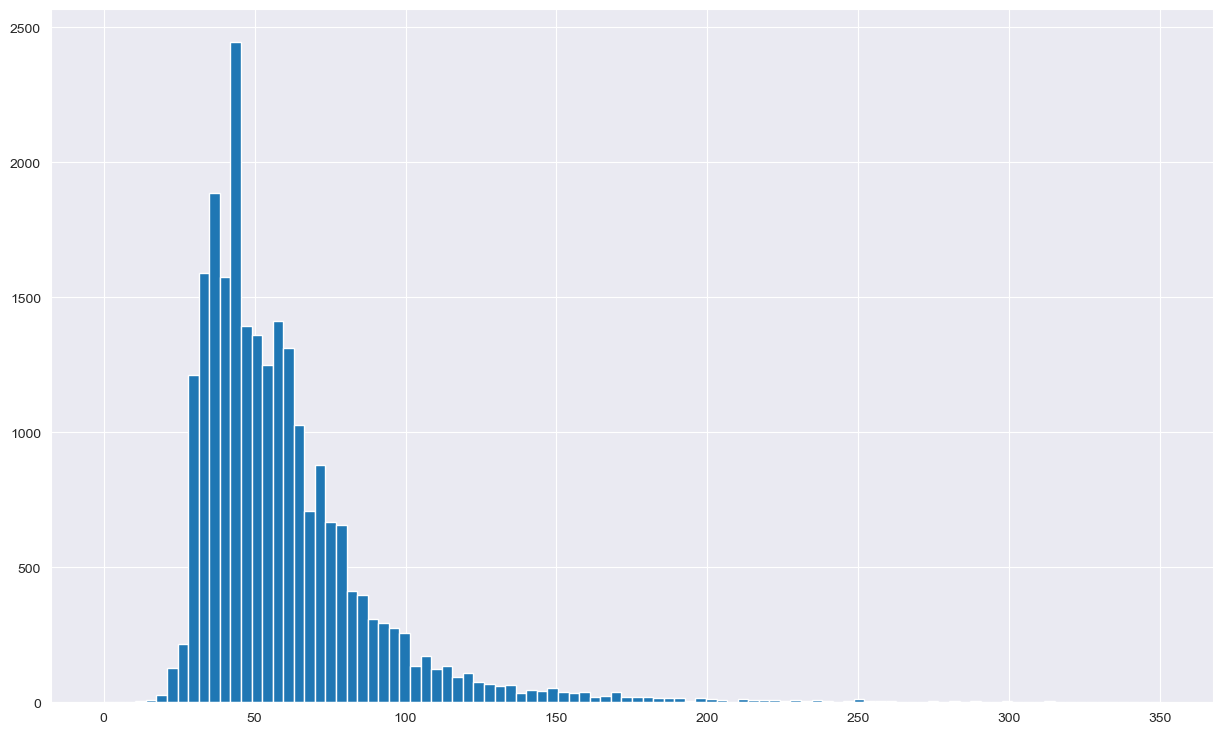

In [78]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,350));

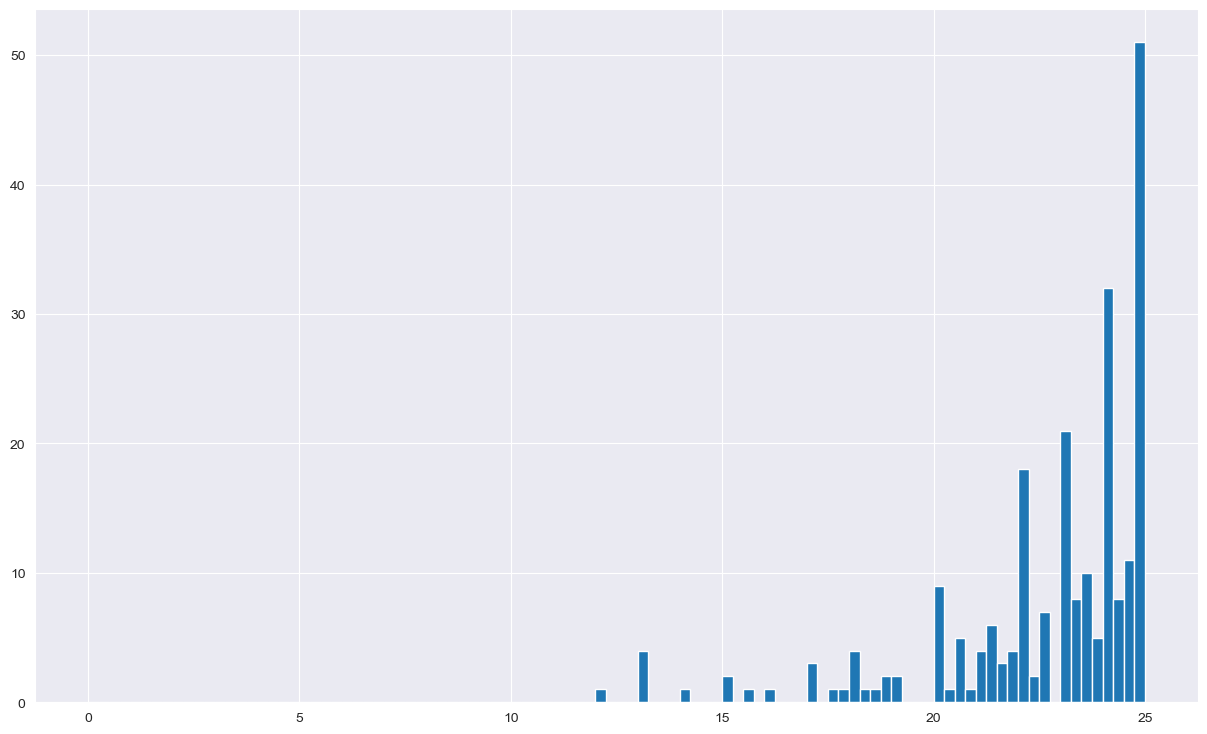

In [79]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,25));

In [80]:
result_range = (20,250)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) |
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["total_area"] > 250]): 79
len(data[data["total_area"] < 20]): 25
len(data): 23415
len(data): 23311


In [81]:
#Дальше столбец "rooms"
column_name = "rooms"

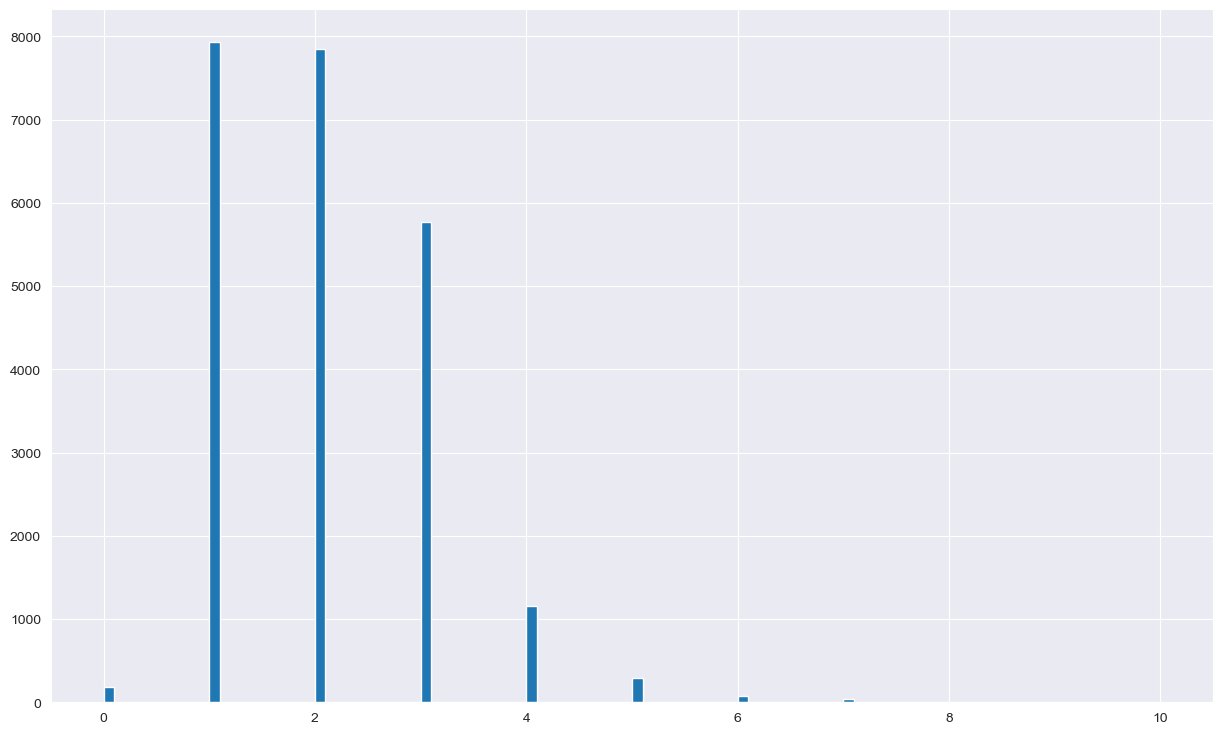

In [82]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,10));

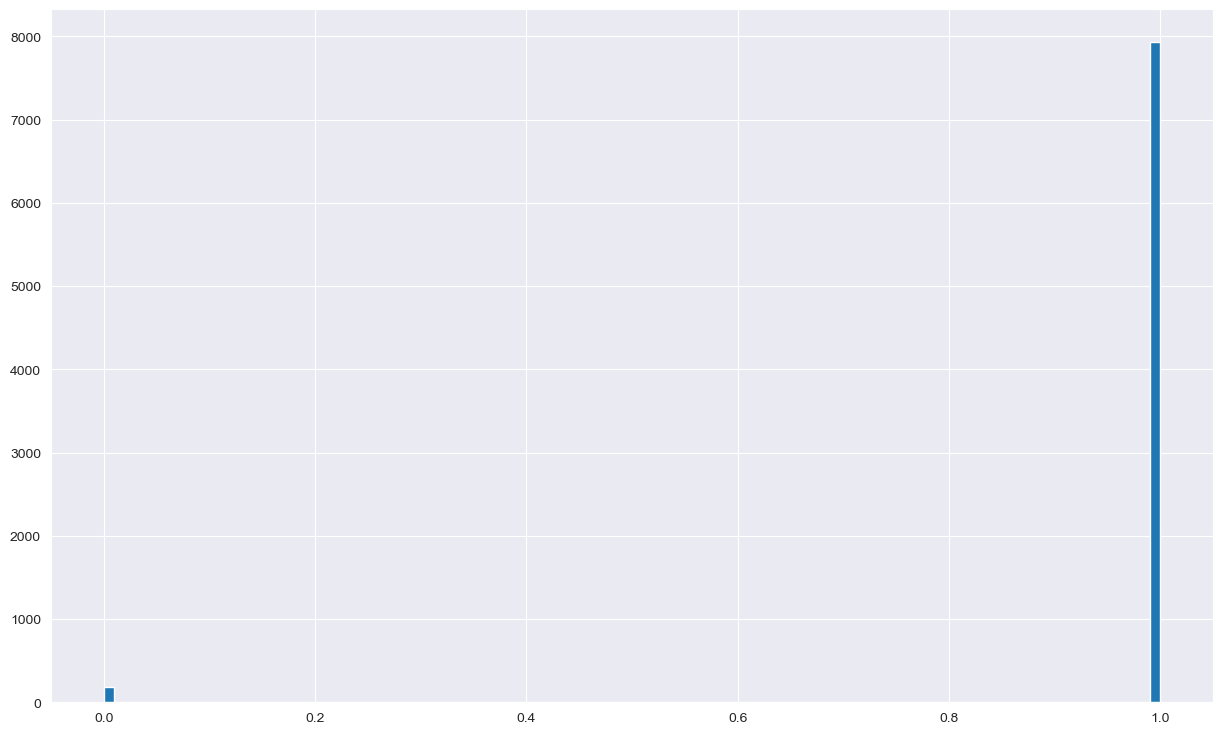

In [83]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,1));

In [84]:
result_range = (1,7)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) |
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["rooms"] > 7]): 14
len(data[data["rooms"] < 1]): 188
len(data): 23311
len(data): 23109


In [85]:
#Дальше столбец "ceiling_height"
column_name = "ceiling_height"

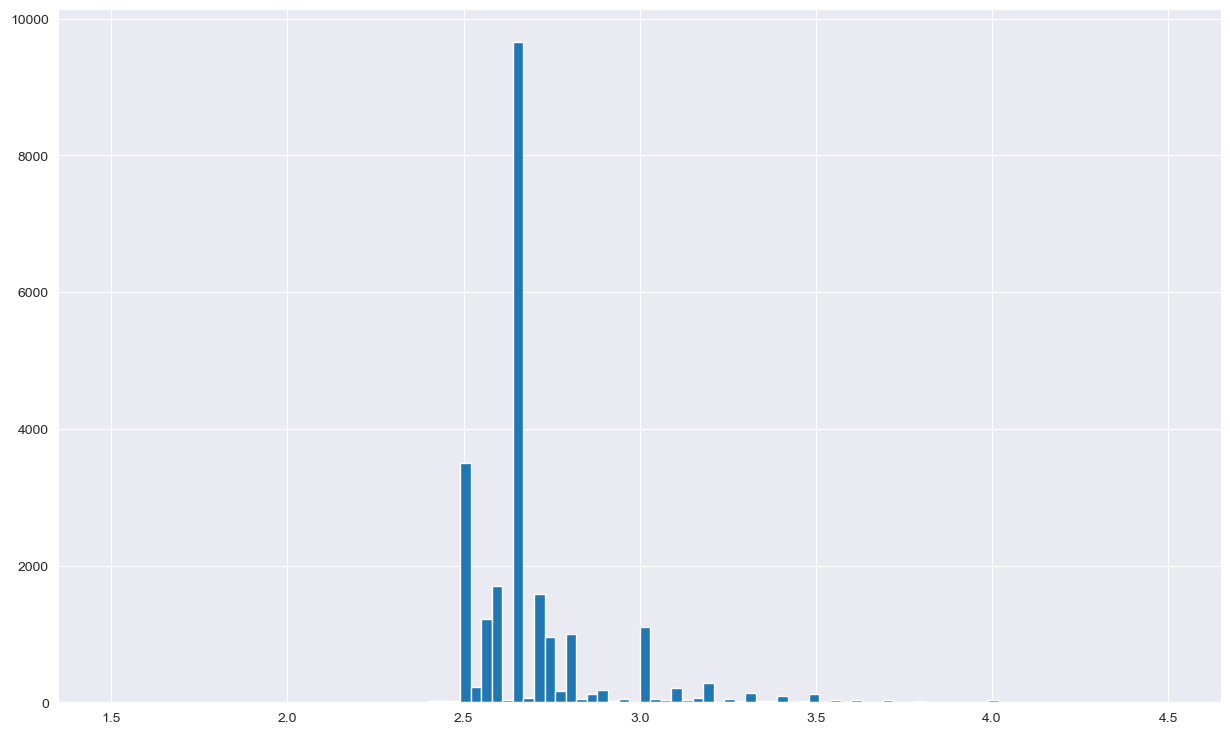

In [86]:
data[column_name].hist(bins=100,figsize=(15,9),range=(1.5,4.5));

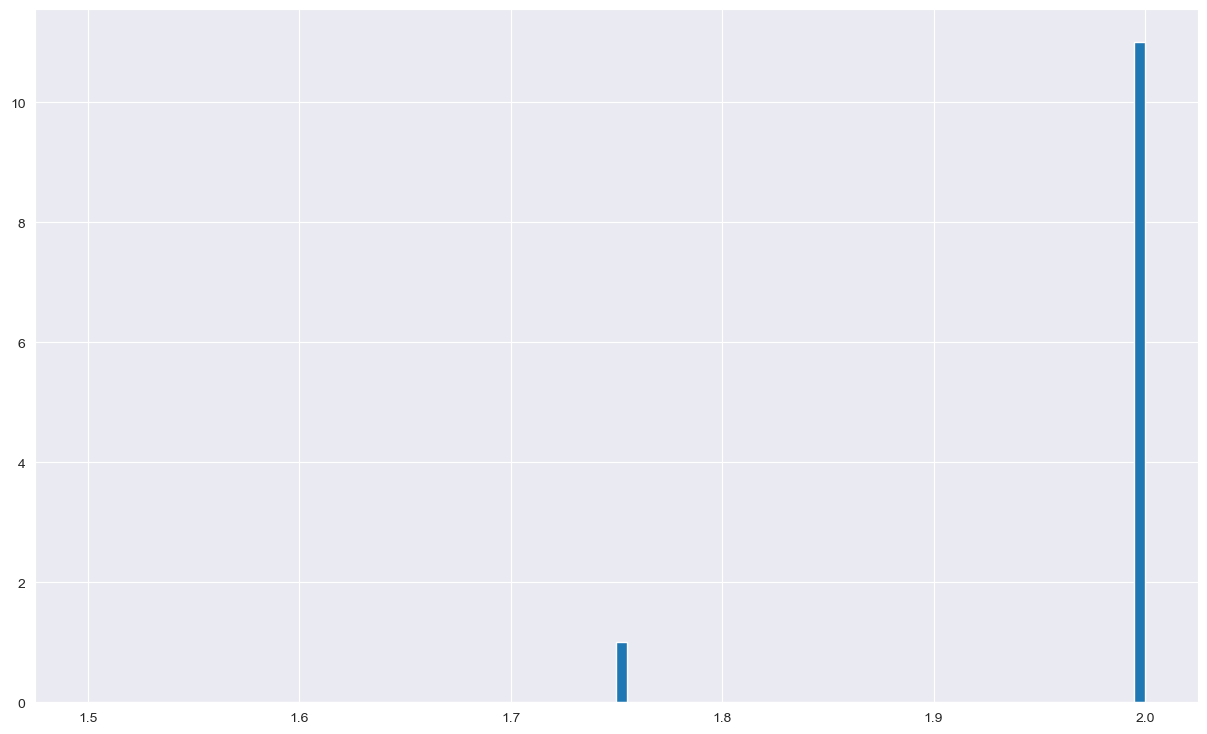

In [87]:
data[column_name].hist(bins=100,figsize=(15,9),range=(1.5,2));

In [88]:
result_range = (2,4)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) |
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["ceiling_height"] > 4]): 61
len(data[data["ceiling_height"] < 2]): 3
len(data): 23109
len(data): 23045


In [89]:
#Дальше столбец "floors_total"
column_name = "floors_total"

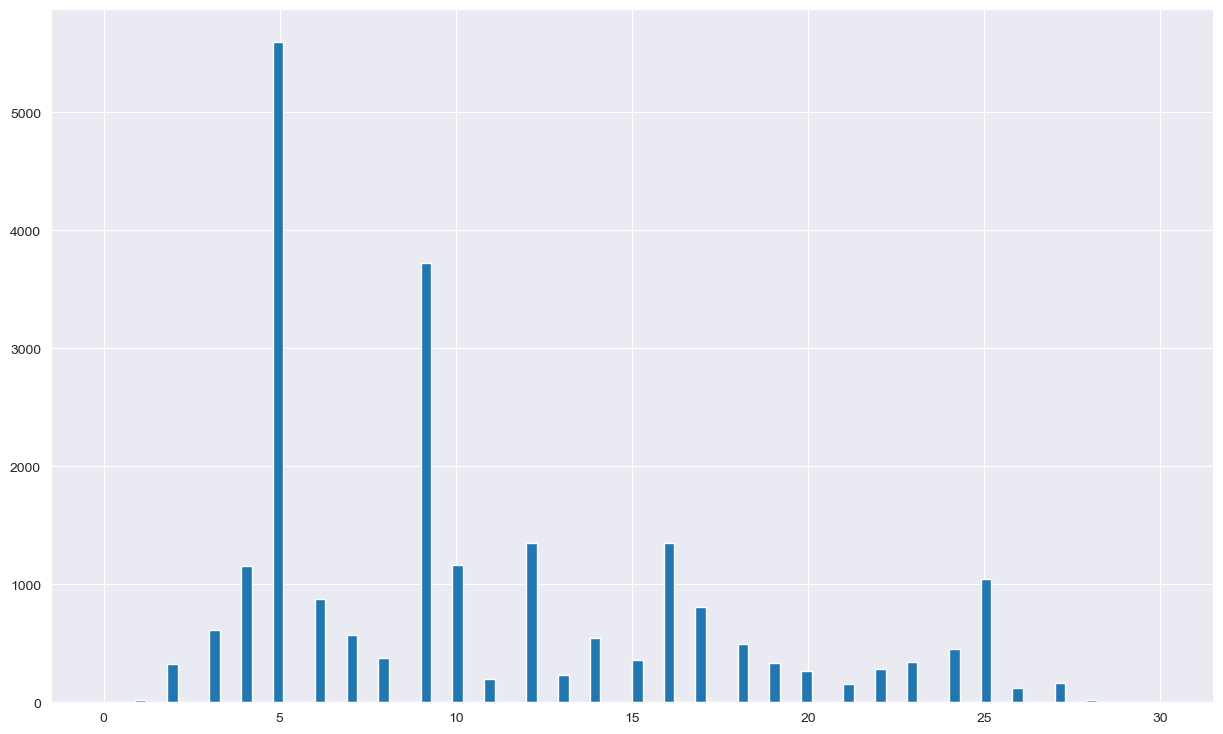

In [90]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,30));

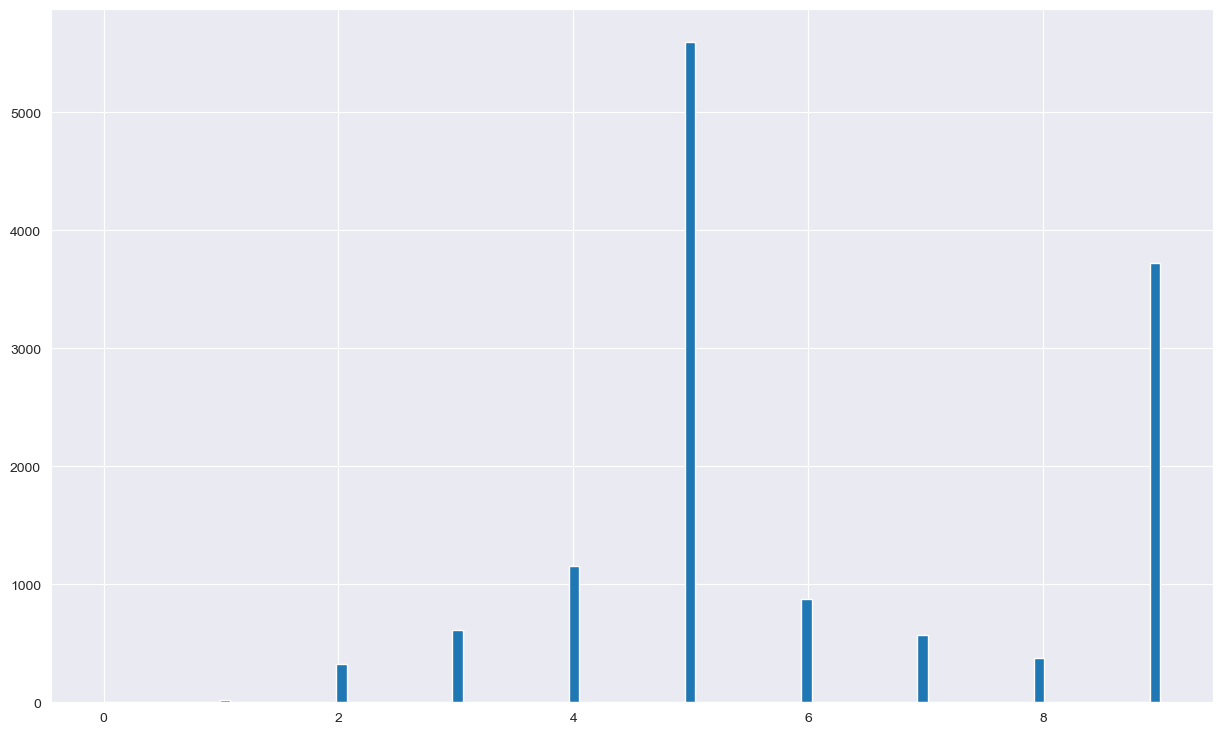

In [91]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,9));

In [92]:
result_range = (0,25)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) | 
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["floors_total"] > 25]): 333
len(data[data["floors_total"] < 0]): 0
len(data): 23045
len(data): 22712


In [93]:
#Дальше столбец "living_area"
column_name = "living_area"

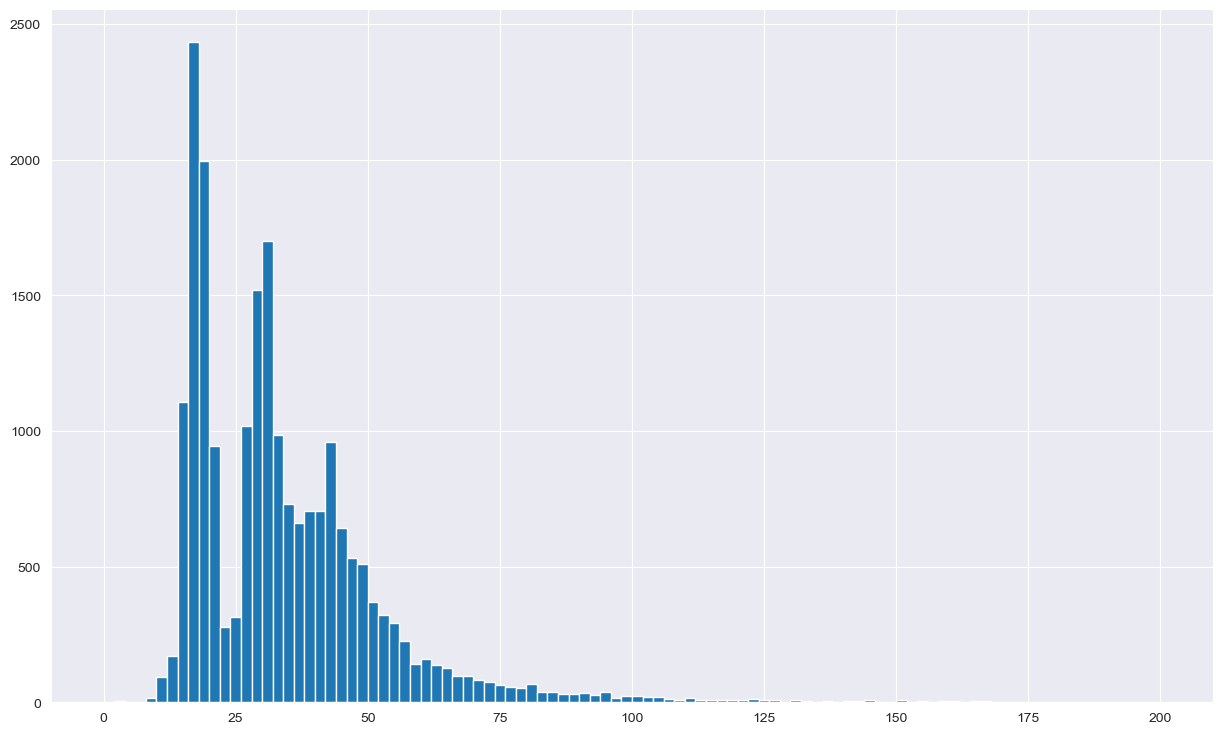

In [94]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,200));

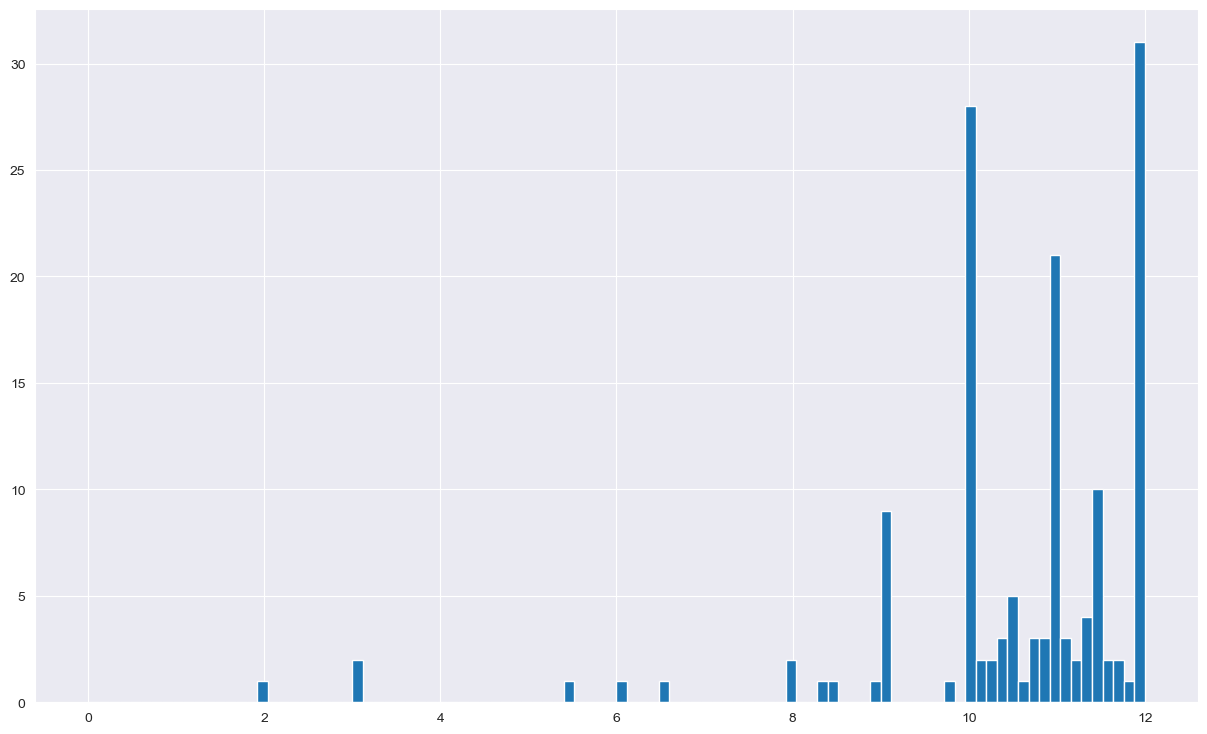

In [95]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,12));

In [96]:
result_range = (10,150)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) | 
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["living_area"] > 150]): 36
len(data[data["living_area"] < 10]): 21
len(data): 22712
len(data): 22655


In [97]:
#Дальше столбец "floor"
#его я пропускаю (так как не похоже, что есть сильно выделяющиеся значения, после того,
#как я удалил аномалии в столбце "floors_total")
column_name = "floor"

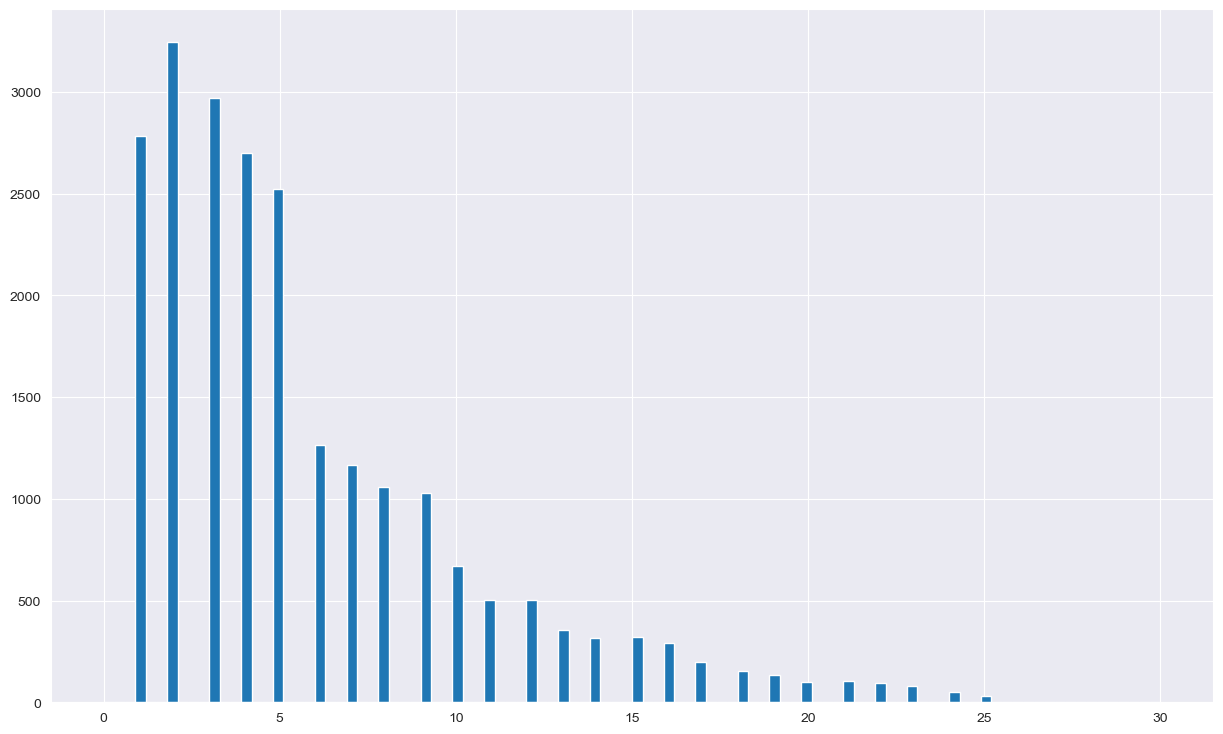

In [98]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,30));

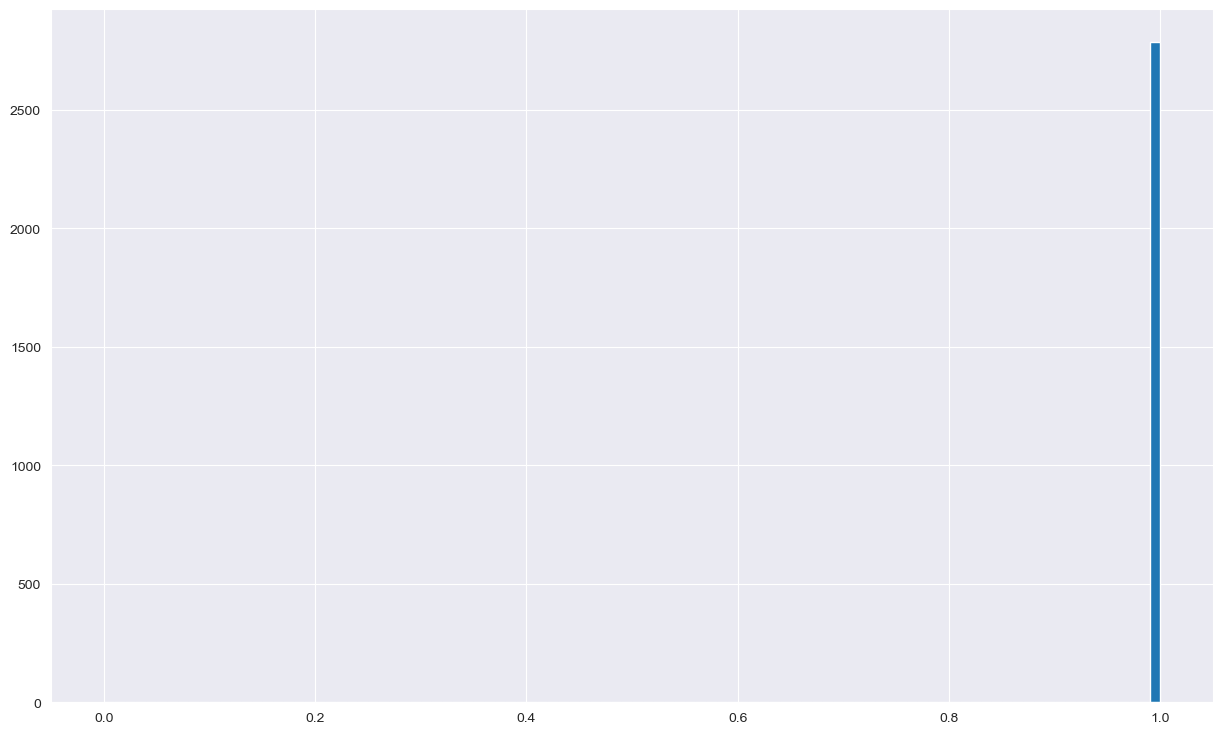

In [99]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,1));

In [100]:
#Дальше столбец "kitchen_area"
column_name = "kitchen_area"

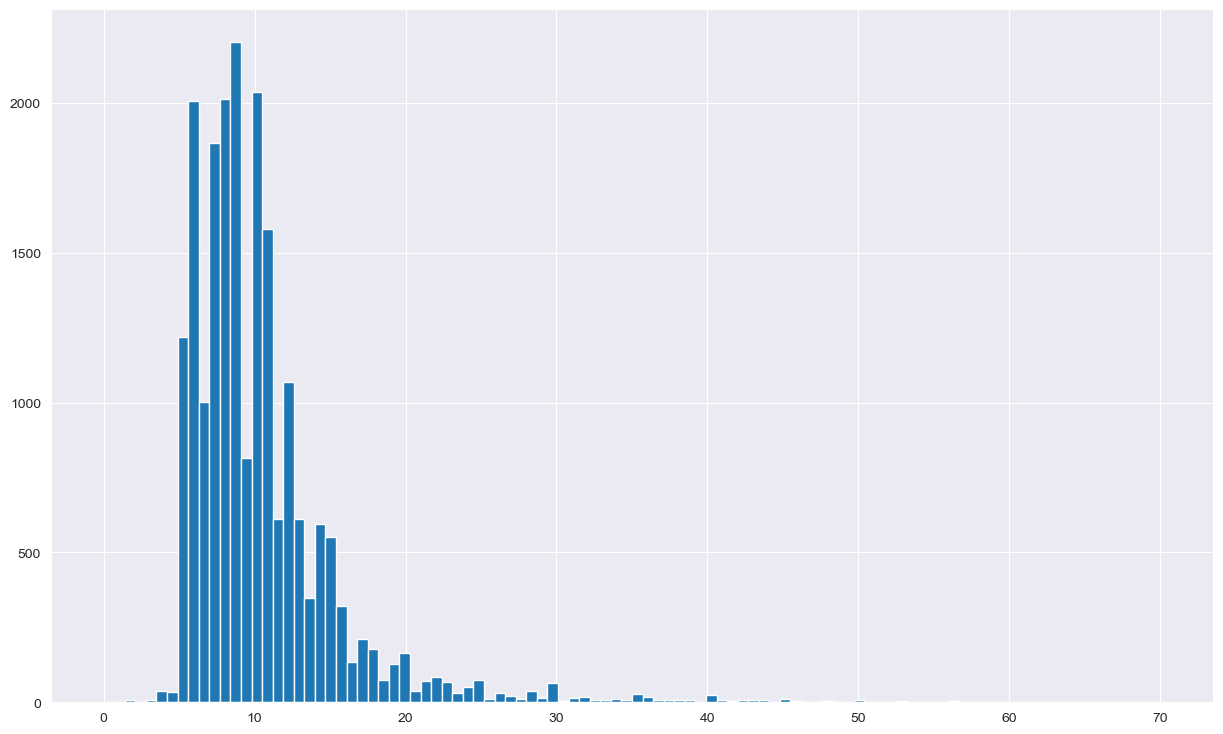

In [101]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,70));

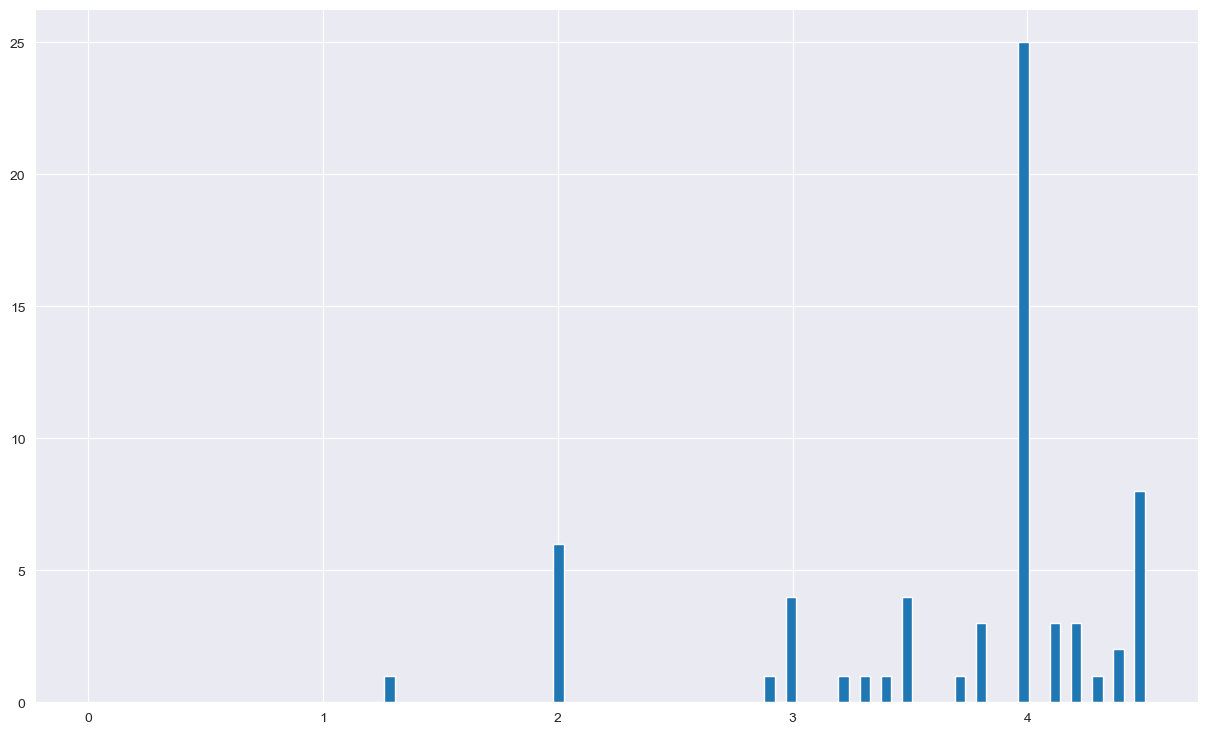

In [102]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,4.5));

In [103]:
result_range = (4.5,50)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) | 
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["kitchen_area"] > 50]): 27
len(data[data["kitchen_area"] < 4.5]): 57
len(data): 22655
len(data): 22571


In [104]:
#Дальше столбец "days_exposition"
column_name = "days_exposition"

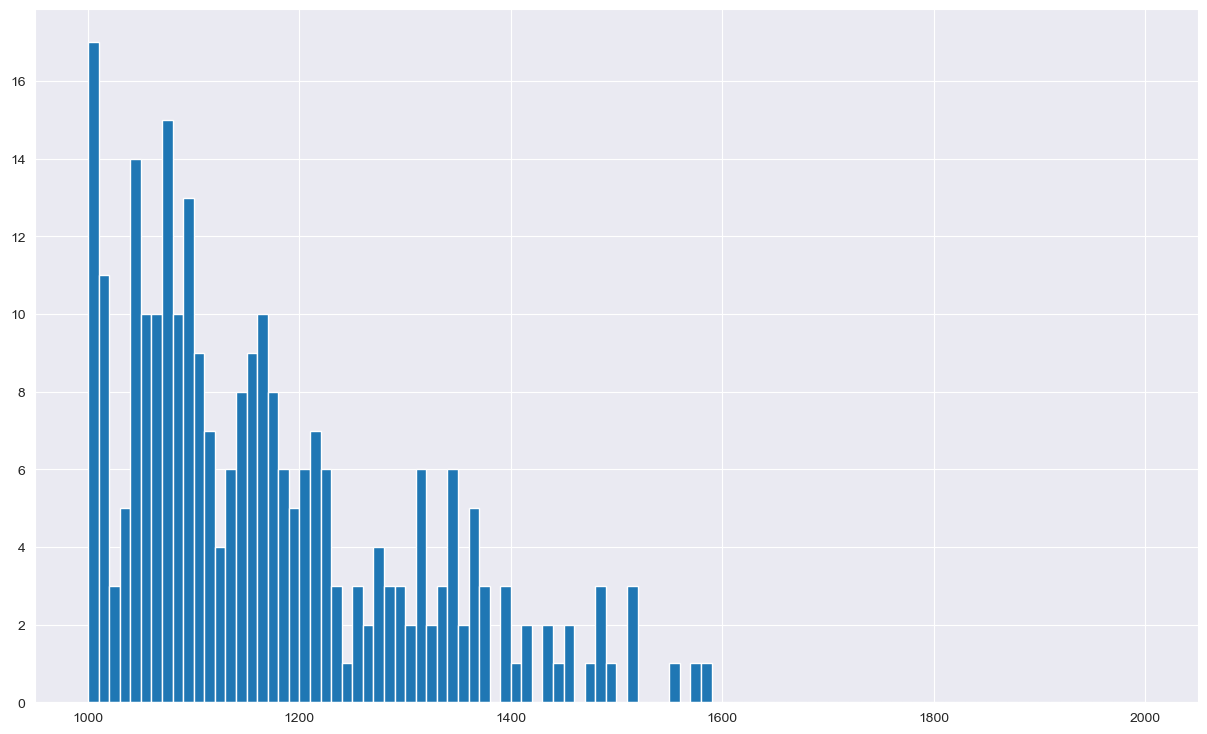

In [105]:
data[column_name].hist(bins=100,figsize=(15,9),range=(1000,2000));

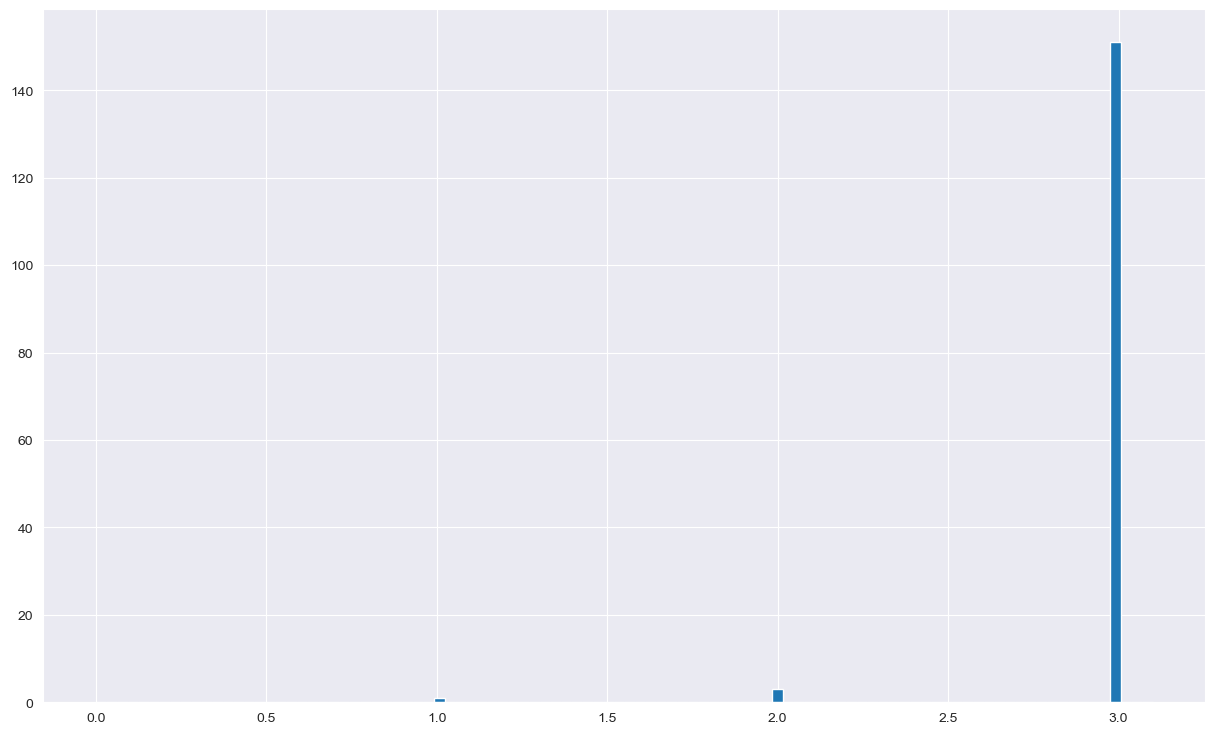

In [106]:
data[column_name].hist(bins=100,figsize=(15,9),range=(0,3.1));

In [107]:
result_range = (3.1,1000)
print(f'len(data[data["{column_name}"] > {result_range[1]}]): {len(data[data[column_name] > result_range[1]])}')
print(f'len(data[data["{column_name}"] < {result_range[0]}]): {len(data[data[column_name] < result_range[0]])}')
print(f'len(data): {len(data)}')
data = data.loc[(data[column_name].isna()) | 
                ((data[column_name] >= result_range[0]) & (data[column_name] <= result_range[1]))]
print(f'len(data): {len(data)}')

len(data[data["days_exposition"] > 1000]): 267
len(data[data["days_exposition"] < 3.1]): 155
len(data): 22571
len(data): 22149


##### **Какие особенности данных я обнаружил**

В столбце "ceiling_height" вероятно пропустили точку между числами из-за чего поялвились слишком большие значения для высоты потолка

In [108]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22149 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22149 non-null  int64         
 1   last_price            22149 non-null  int64         
 2   total_area            22149 non-null  float64       
 3   first_day_exposition  22149 non-null  datetime64[ns]
 4   rooms                 22149 non-null  int64         
 5   ceiling_height        22149 non-null  float64       
 6   floors_total          22070 non-null  float64       
 7   living_area           20386 non-null  float64       
 8   floor                 22149 non-null  int64         
 9   is_apartment          2606 non-null   object        
 10  studio                22149 non-null  bool          
 11  open_plan             22149 non-null  bool          
 12  kitchen_area          20201 non-null  float64       
 13  balcony         

In [109]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,149.00","22,149.00","22,149.00","19,137.00","22,149.00","20,386.00","20,201.00","22,149.00","22,070.00"
min,1.00,20.00,2.00,4.00,"1,000,000.00",10.00,4.50,1.00,1.00
max,7.00,250.00,4.00,"1,000.00","79,339,000.00",150.00,50.00,25.00,25.00


In [110]:
# check
df_check = pd.read_csv('C:/Users/dmitr/Jupiter_Notebook/datasets/Module_1/real_estate_data.csv', sep = '\t')

In [111]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


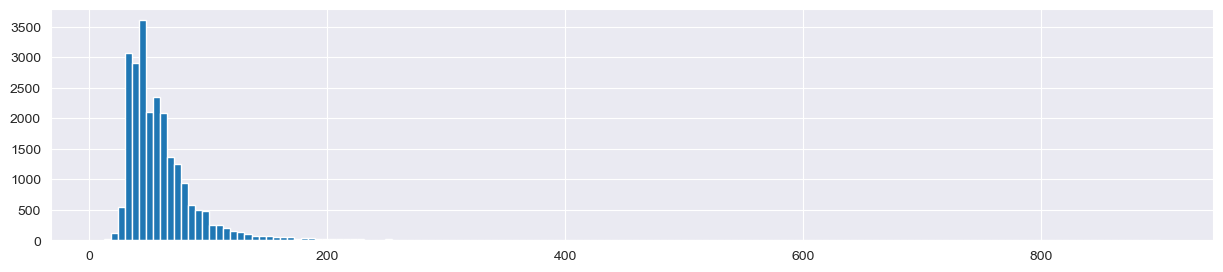

In [112]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

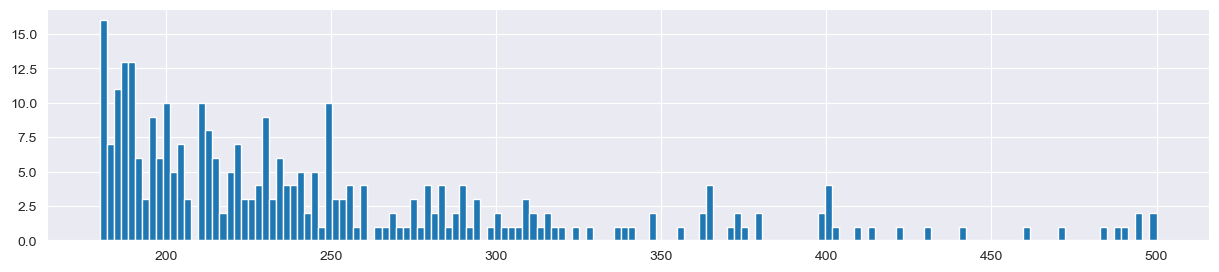

In [113]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

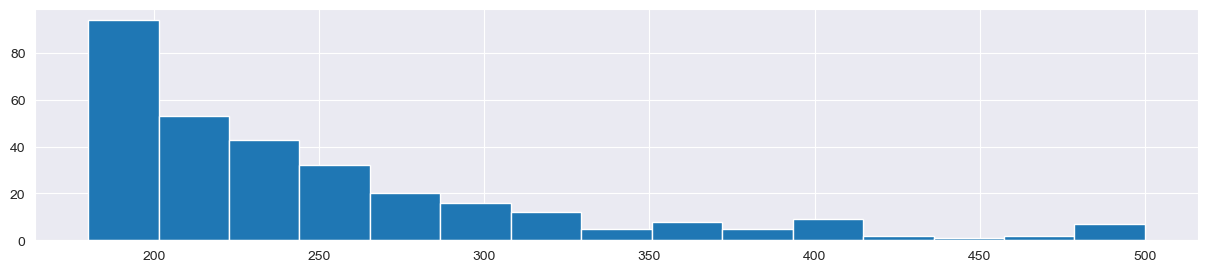

In [114]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

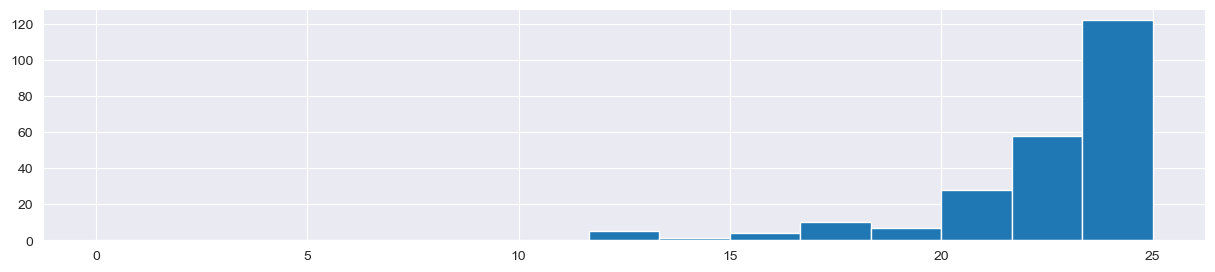

In [115]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [116]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    df_check[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,0.00,20.00,2.30,3.00,"562,188.00",10.00,3.77,1.00,2.00
0.010000,1.00,25.20,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.500000,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.10,4.00,9.00
0.990000,5.00,197.21,3.83,"1,068.66","36,000,000.00",120.00,35.09,23.00,26.00
0.998800,8.00,380.00,25.00,"1,369.90","124,772,448.00",219.69,60.00,26.00,35.00


In [117]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,1.00,22.00,2.40,4.00,"1,050,000.00",10.00,4.80,1.00,2.00
0.010000,1.00,28.00,2.50,5.00,"1,300,000.00",13.37,5.00,1.00,2.00
0.500000,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.00,4.00,9.00
0.990000,5.00,165.00,3.50,864.64,"27,845,200.00",99.60,31.20,22.00,25.00
0.998800,6.42,214.42,4.00,979.00,"55,897,683.42",135.45,45.00,25.00,25.00


### Посчитайте и добавьте в таблицу новые столбцы

In [118]:
#цена одного квадратного метра квартиры
data['price_per_square_meter'] = pd.Series(data['last_price']/data['total_area'])

#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['first_day_exposition_weekday'] = data['first_day_exposition'].apply(lambda x: x.weekday())

#месяц публикации объявления
data['first_day_exposition_month'] = data['first_day_exposition'].apply(lambda x: x.month)

#год публикации объявления
data['first_day_exposition_year'] = data['first_day_exposition'].apply(lambda x: x.year)

#тип этажа квартиры (значения — «‎первый», «последний», «другой»)
def floor_type(row):
    if row['floor']==row['floors_total']:
        row['floor_type'] = 'последний'
        row['floor_type_int'] = 2
        return row
    if row['floor'] == 1:
        row['floor_type'] = 'первый'
        row['floor_type_int'] = 0
        return row
    if row['floor'] > 1 and row['floor'] < row['floors_total']:
        row['floor_type'] = 'другой'
        row['floor_type_int'] = 1
        return row
    else:
        row['floor_type'] = 'некорректный'
        row['floor_type_int'] = -1
data['floor_type'],data['floor_type_int'] = ['',-1]
data = data.apply(floor_type,axis=1)


#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)
def distance_to_the_city_center_in_kilometers(row):
    if not np.isnan(row['cityCenters_nearest']):
        return round(row['cityCenters_nearest']/1000)
data['cityCenters_nearest_km'] = data.apply(distance_to_the_city_center_in_kilometers,axis=1)

print("Количество строк в которых для первого этажа неверно подобран тип: ",len(data[(data['floor'] == 1) & ((data['floor_type'] == 'последний') | (data['floor_type'] == 'другой'))]))

Количество строк в которых для первого этажа неверно подобран тип:  17


### Проведите исследовательский анализ данных

#### **Изучите следующие параметры объектов**

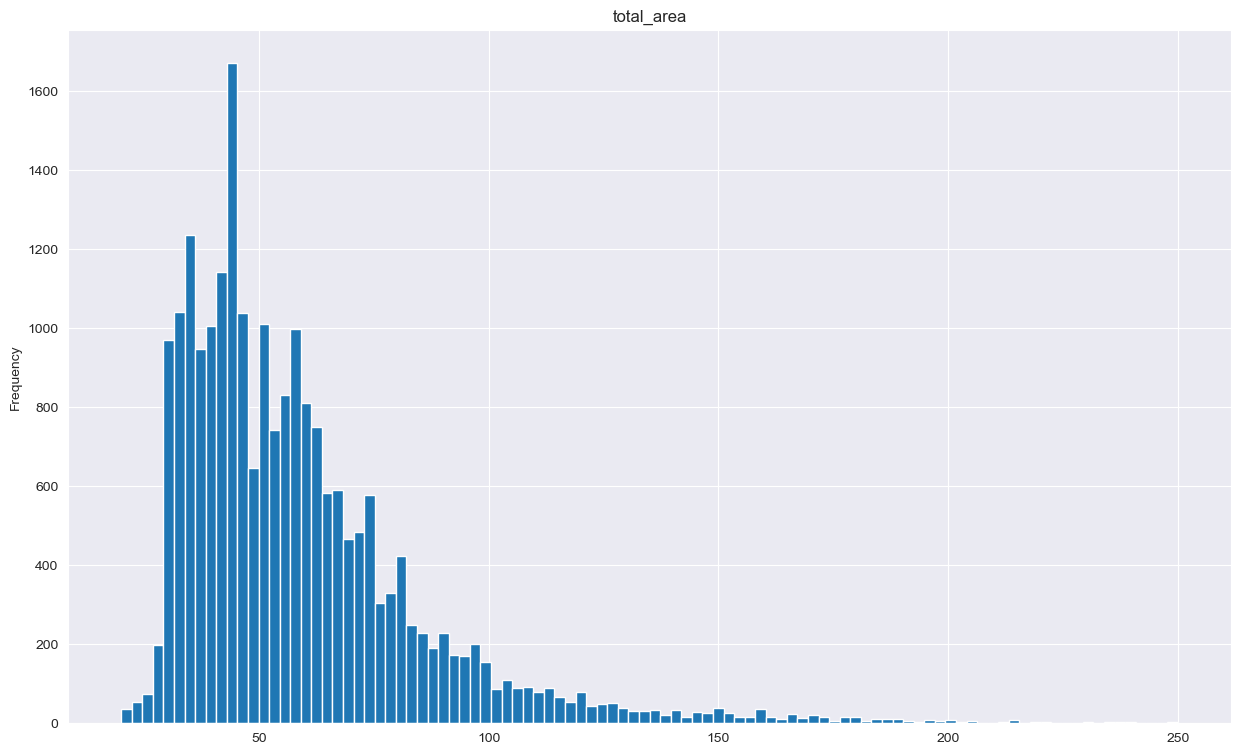

In [119]:
column_list = ['total_area','living_area','kitchen_area','last_price','rooms','ceiling_height','floor',
               'floor_type_int','floors_total','cityCenters_nearest','airports_nearest','parks_nearest',
               'first_day_exposition_weekday','first_day_exposition_month']

column_list_iter = iter(column_list)
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что бо́льшую часть объявлений составляют квартиры с площадью не более 50 кв. м**

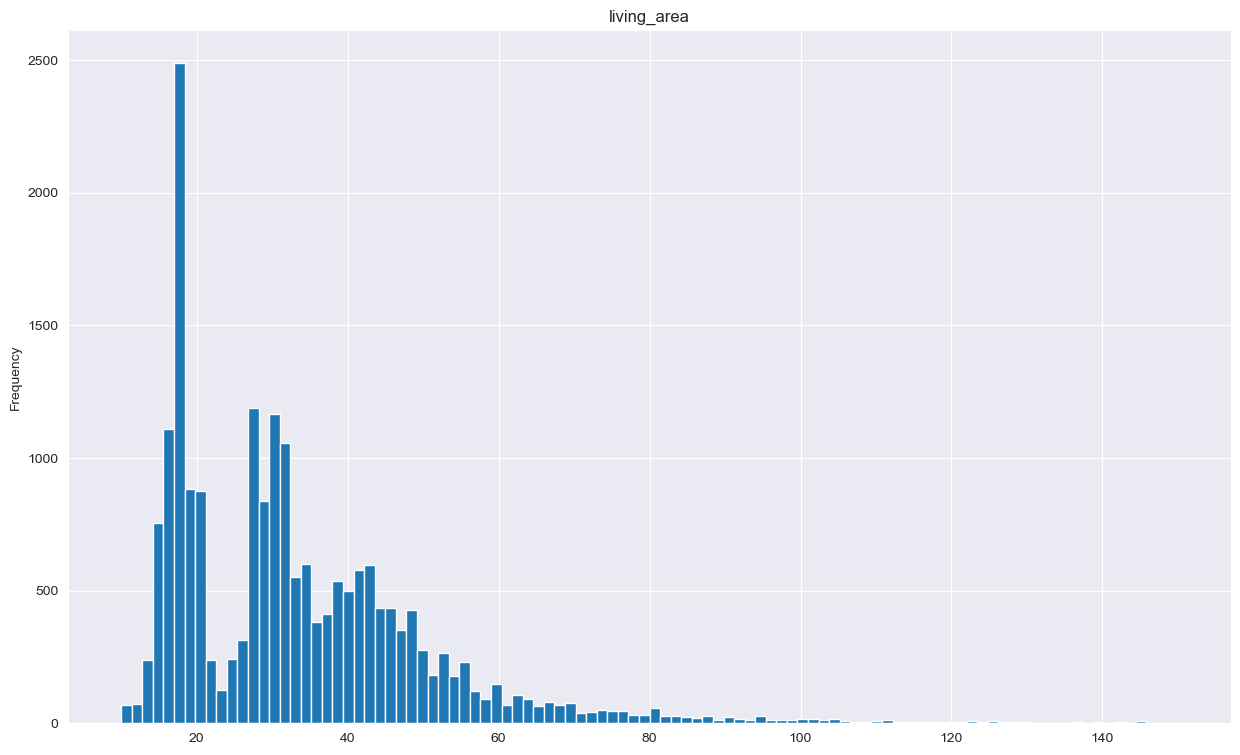

In [120]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что на гистограмме есть ярко выраженный пик (около 18 кв. м)**

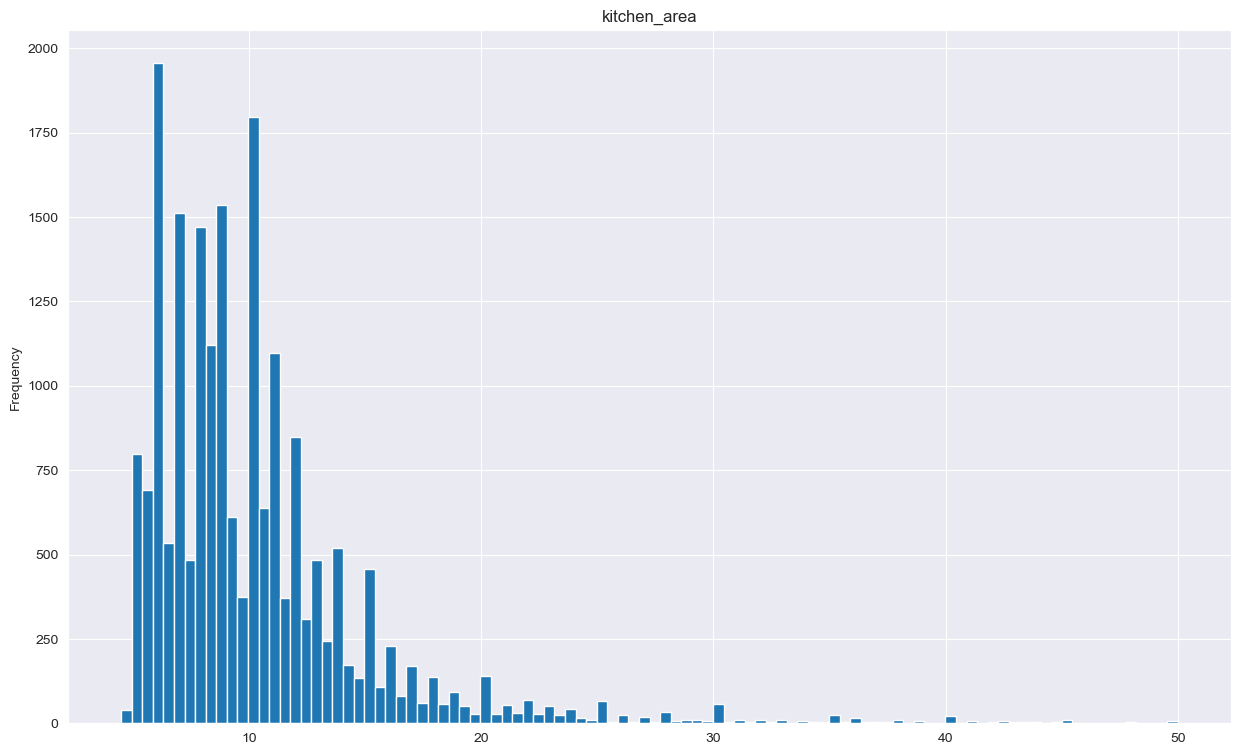

In [121]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить сильные колебания высоты столбцов (до 20 кв. м) на гистограмме**

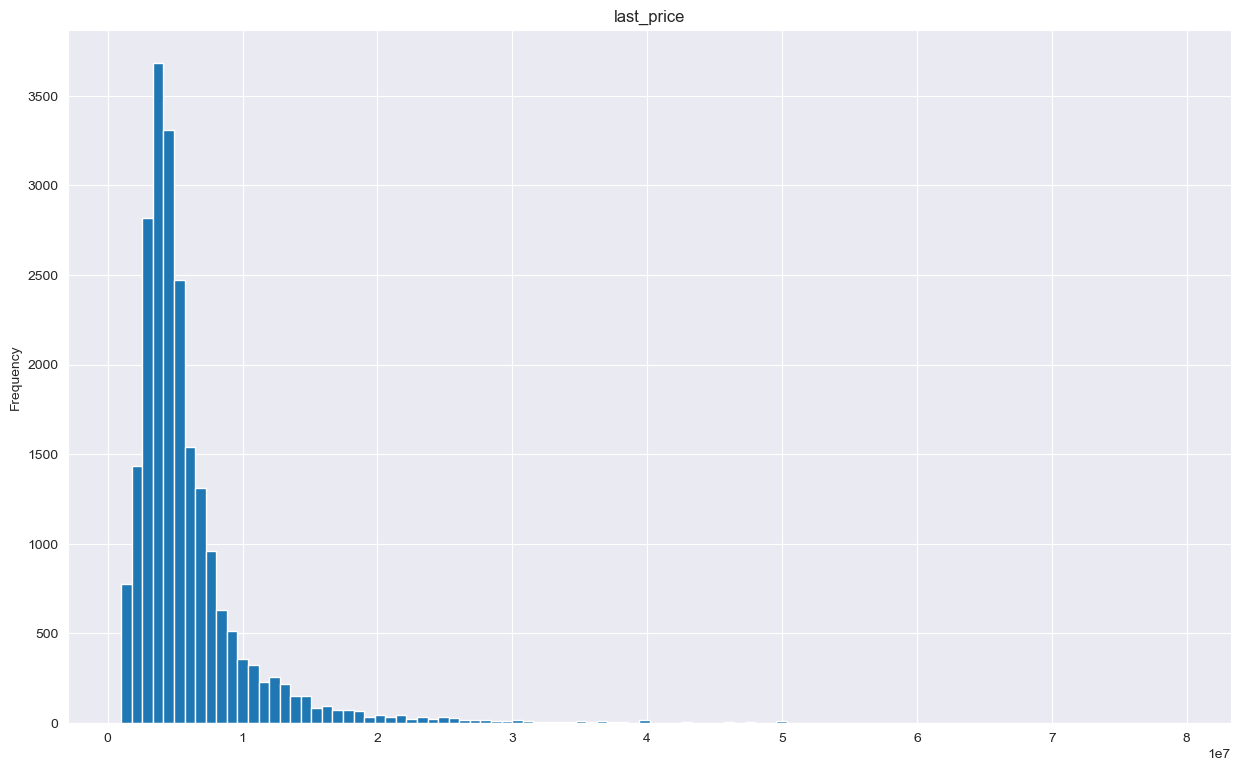

In [122]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что большинство квартир продаются меньше чем за 10 млн. руб.**

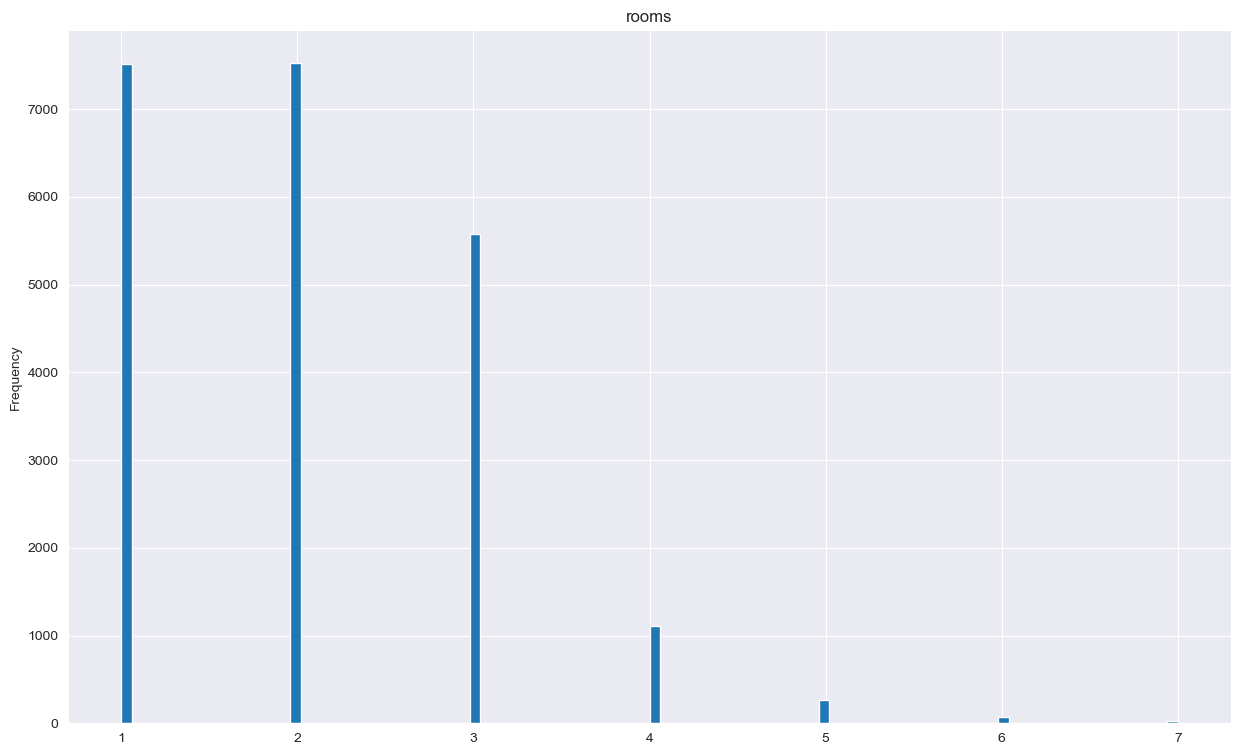

In [123]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что в большинстве случаев, в объявлениях указаны однокомнатные, двухкомнатные или трёхкомнатные квартиры**

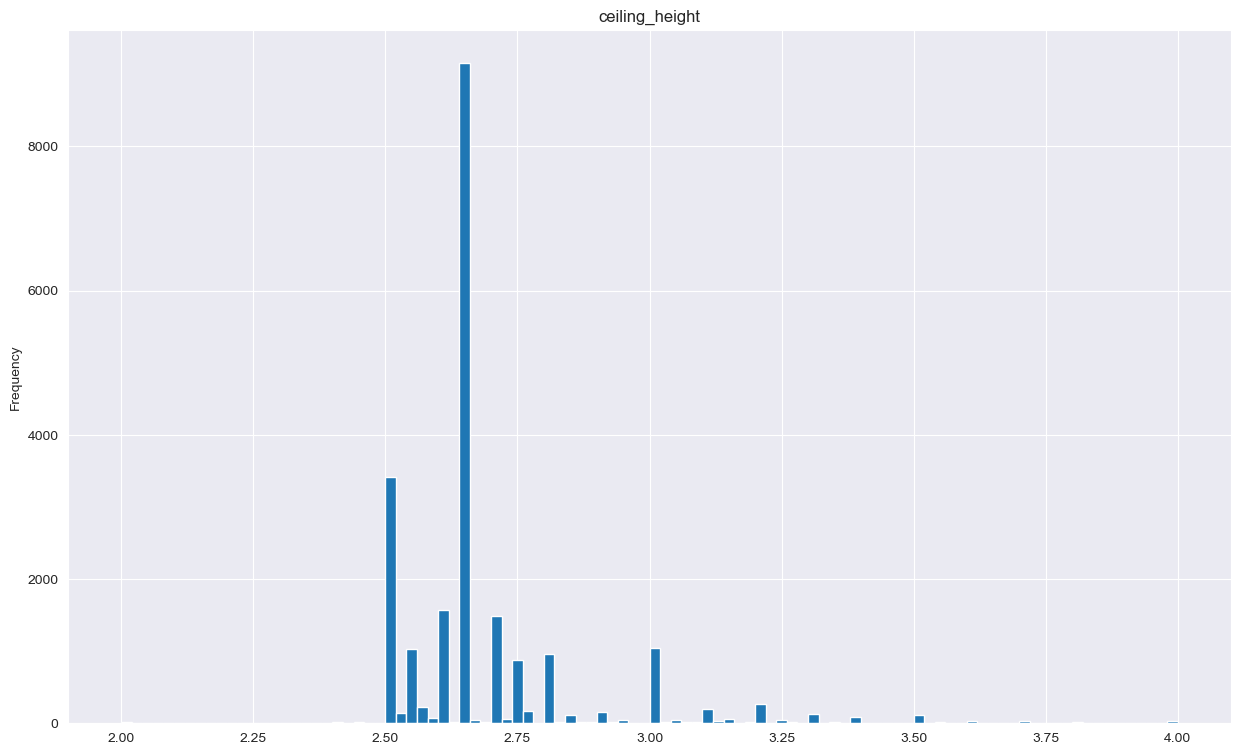

In [124]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что очень много потолков в квартирах имеют высоту около 2.64-2.65, что для стандартных девятиэтажек Советского времени норма.**

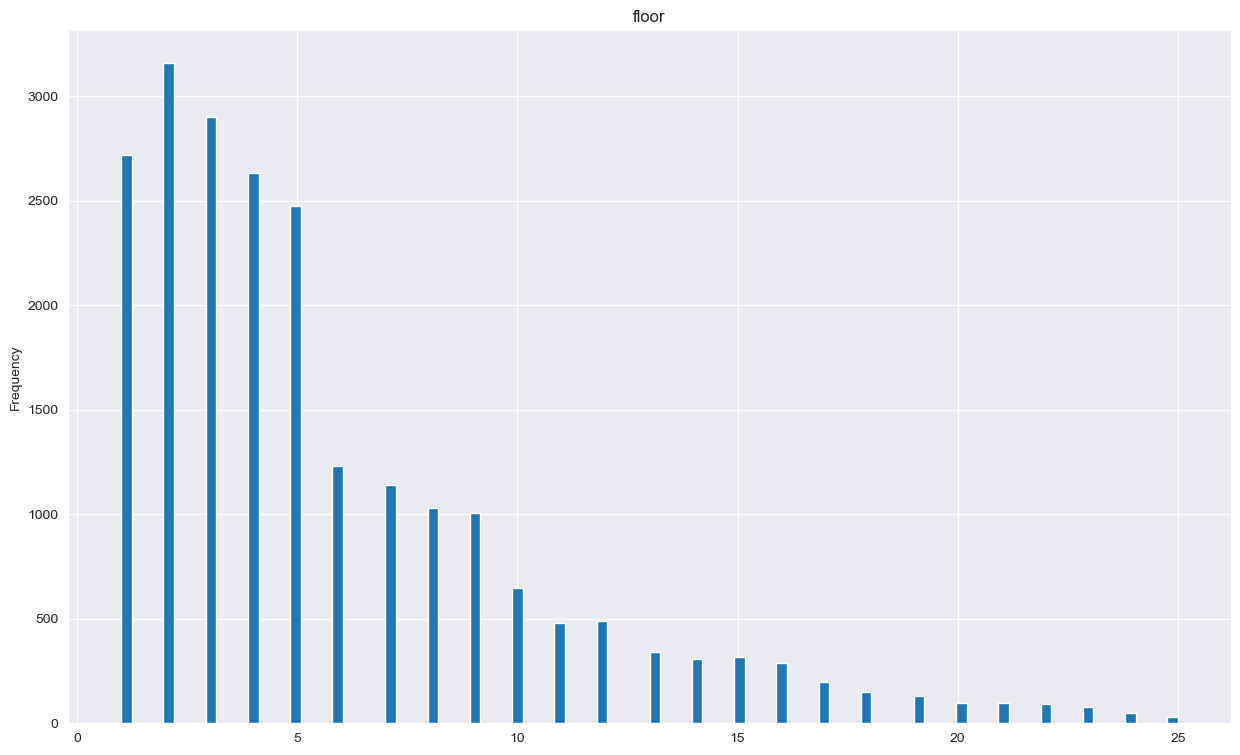

In [125]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что подавляющее большинство квартир расположены не выше 9-ого этажа**

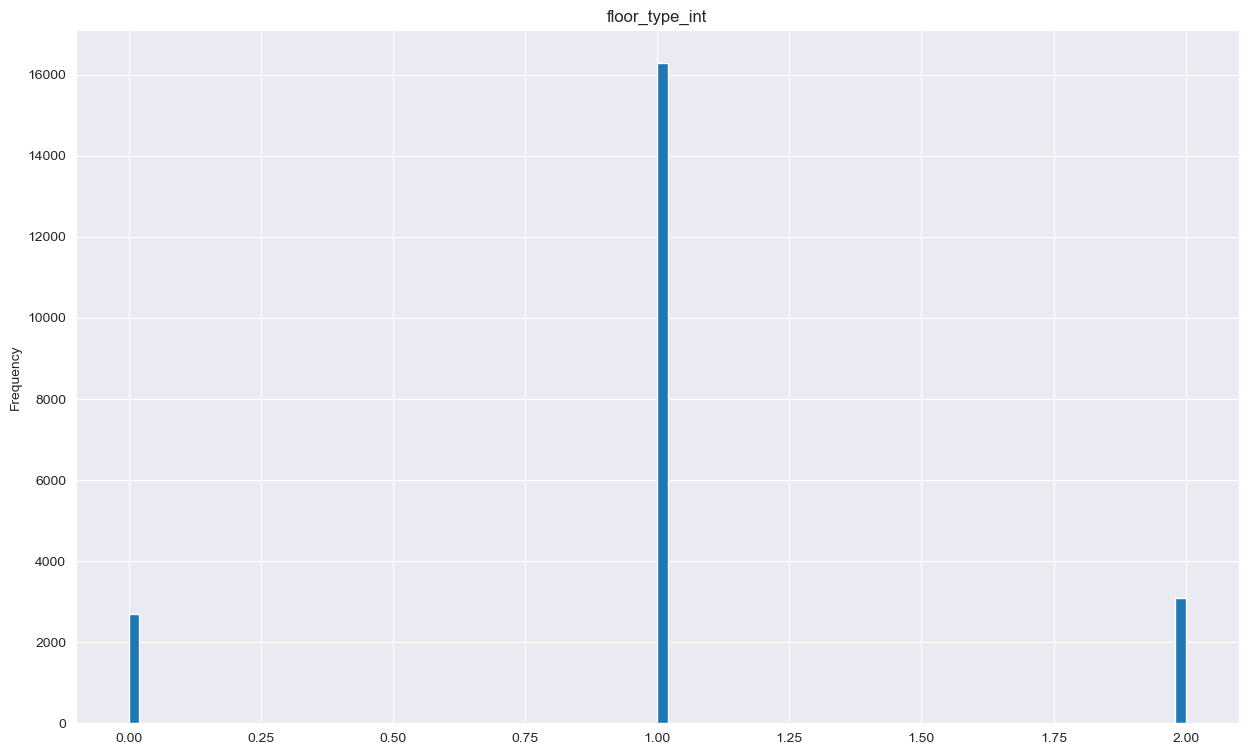

In [126]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что больше всего квартир с типом этажности "другой" (т.е. не первый и не последний этаж в доме), что, несомненно, логично. Также можно отметить, что квартир, расположенных на последнем этаже примерно в 2 раза больше, чем квартир, расположенных на первом этаже**

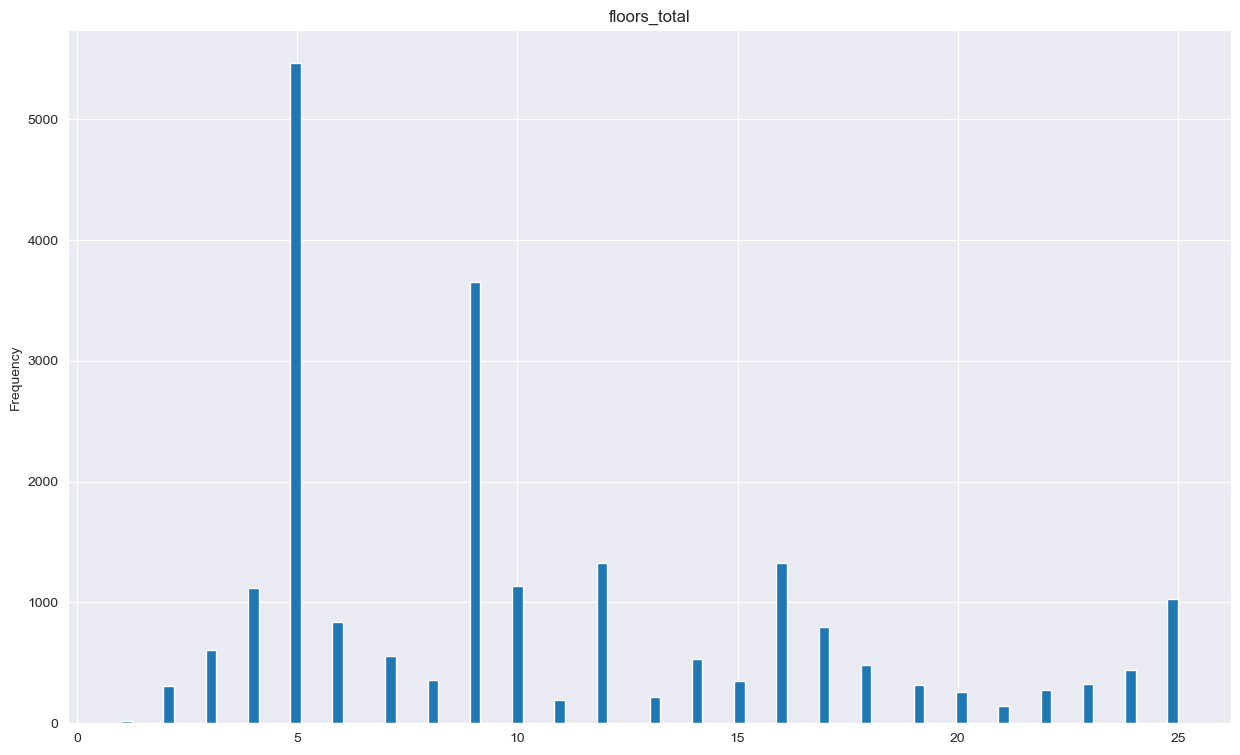

In [127]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что львиная доля рассматриваемых квартир находится в домах с общим числом этажей не более 10**

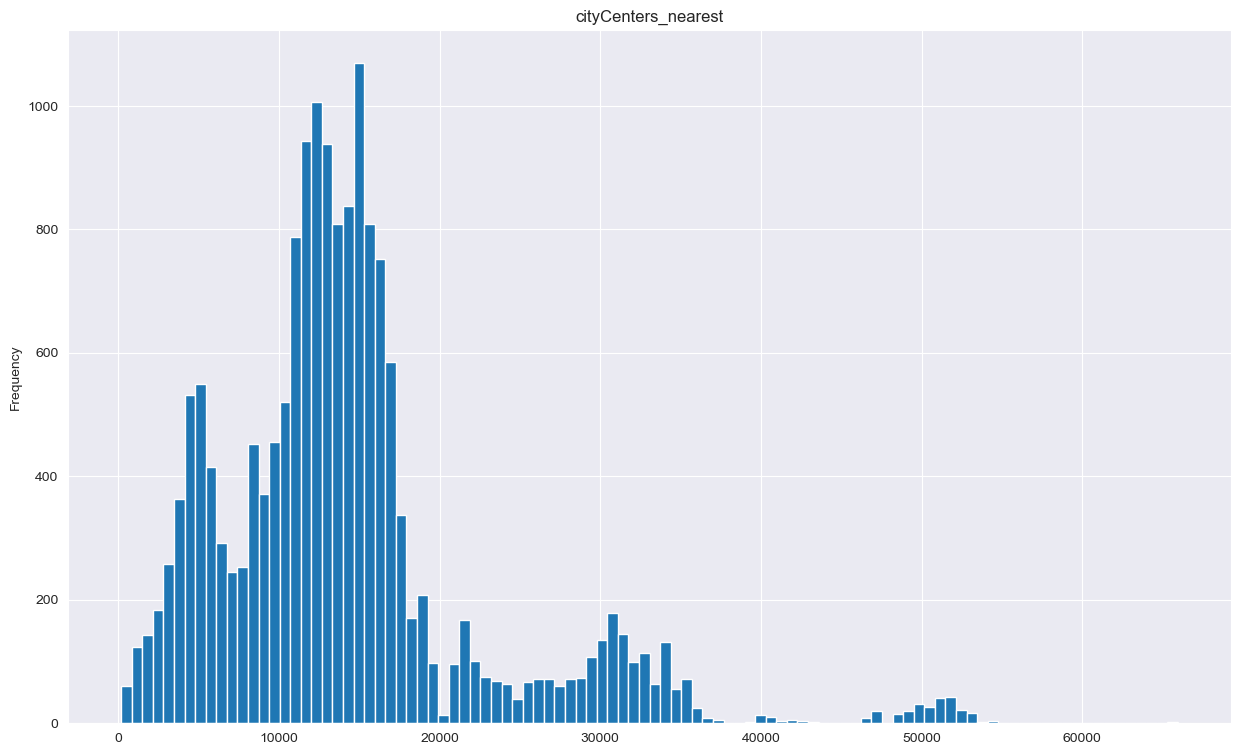

In [128]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что большинство квартир находятся не более чем в 20 км от центра Санкт-Петербурга**

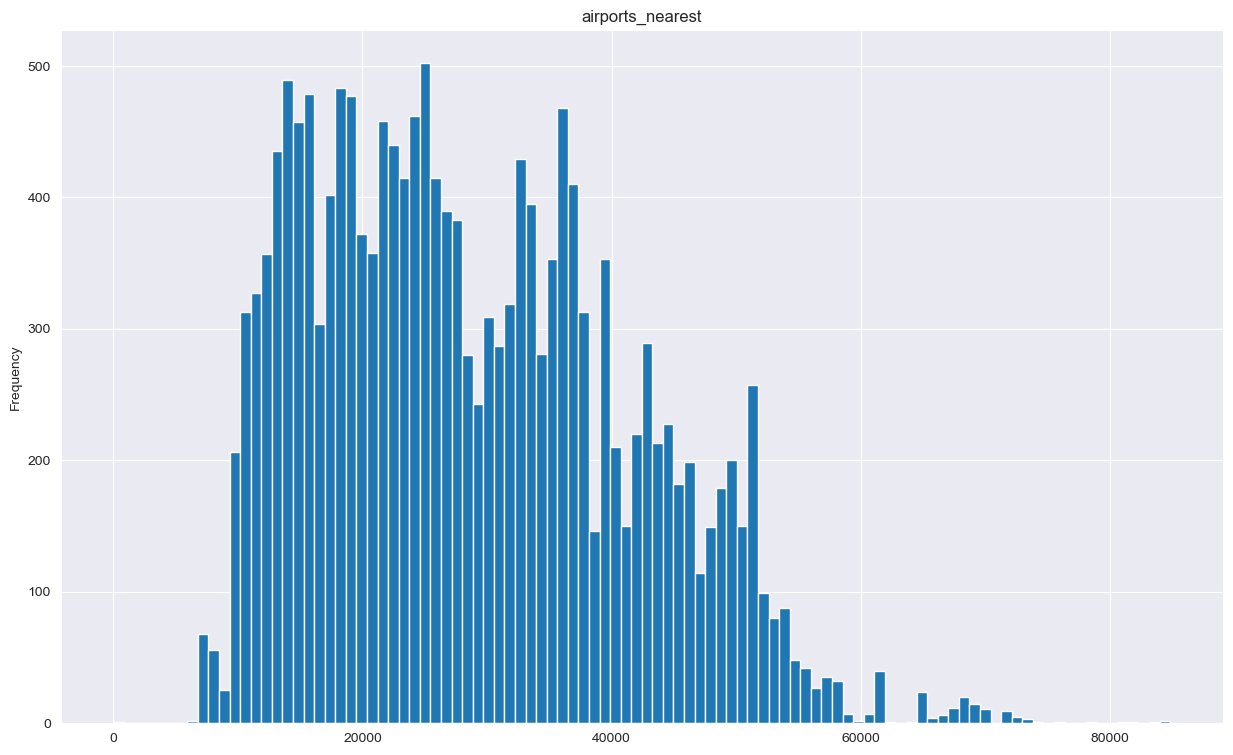

In [129]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что большинство квартир находятся не так уж и близко к ближайшему аэропорту (от 10 до 50 км)**

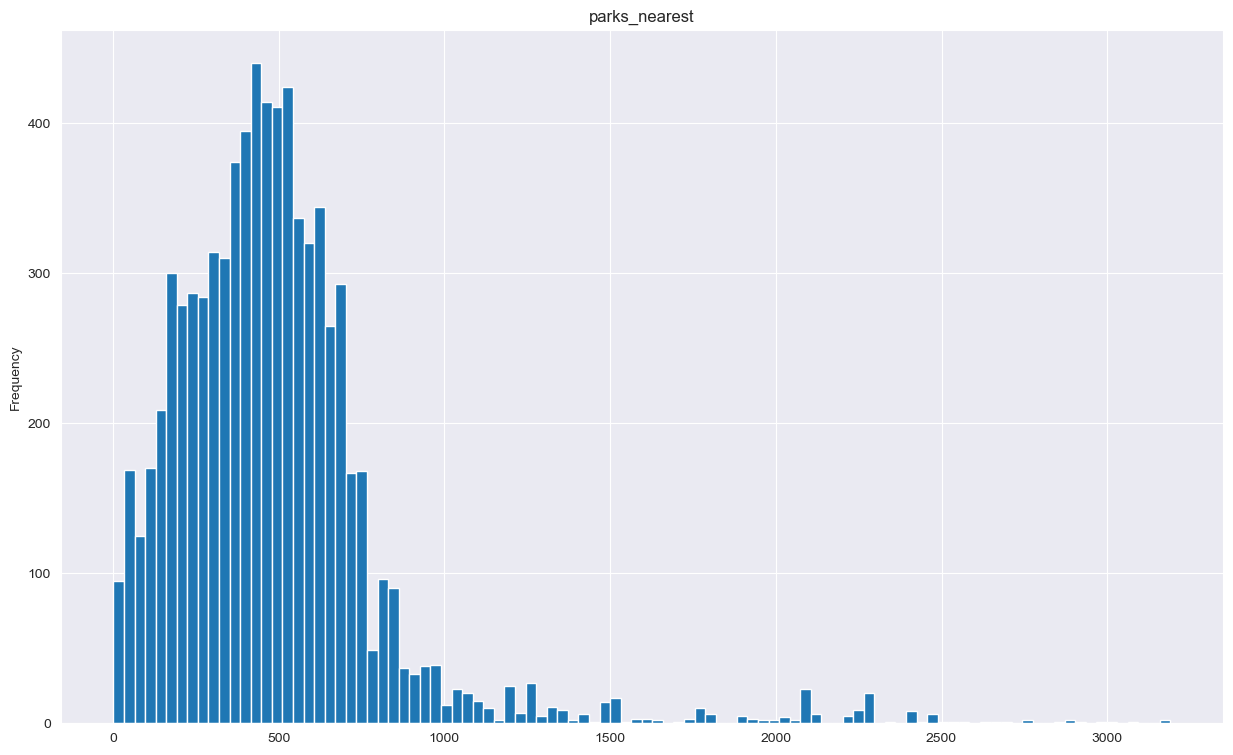

In [130]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что большинство квартир находятся не более чем в 750 м от ближайшего парка, что наводит на гипотезу о большом количестве парков в Санкт-Петергбурге и его окрестностях**

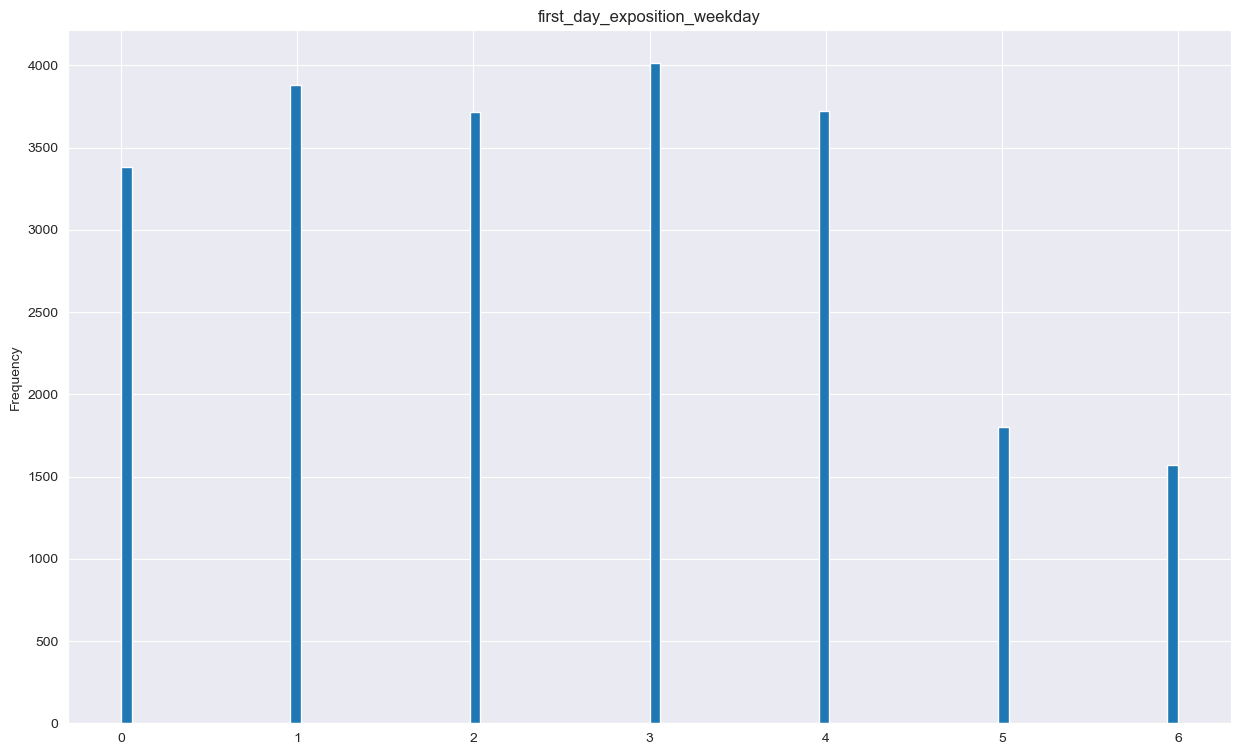

In [131]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что большинство объявлений о продаже квартир были размещены в будние дни**

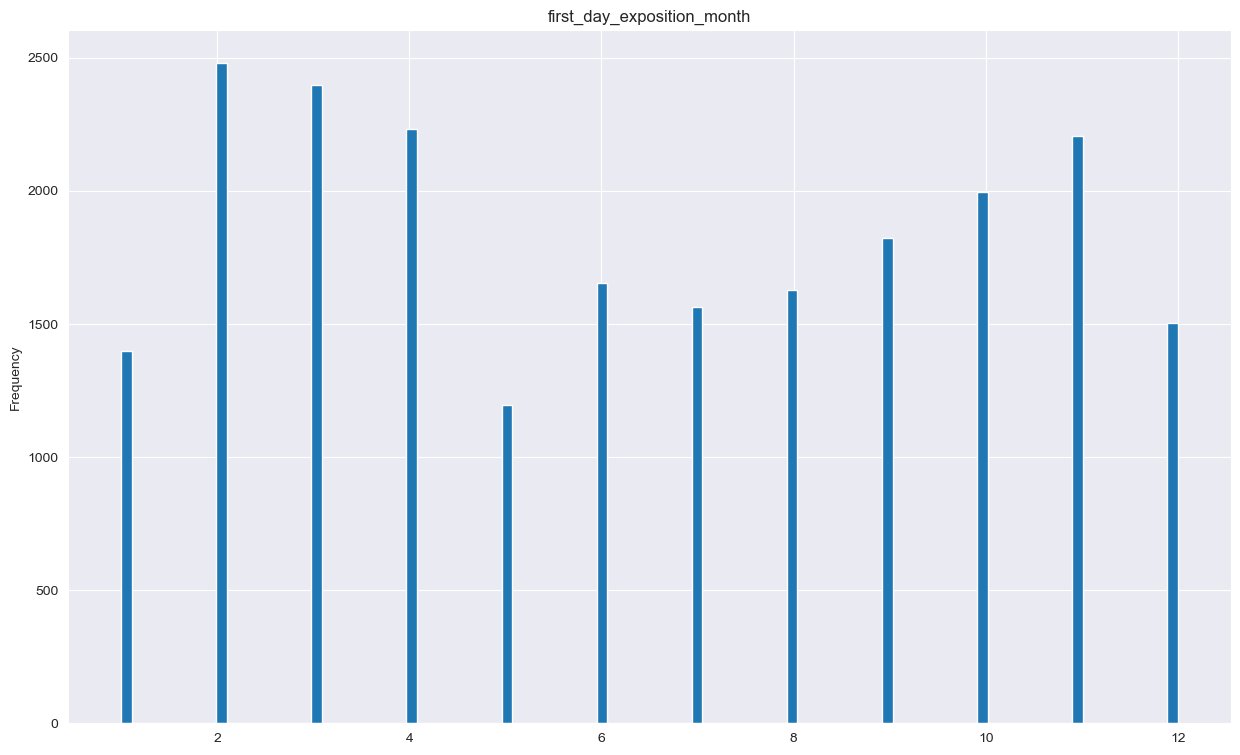

In [132]:
column_name = column_list_iter.__next__()
data[column_name].plot(kind='hist',bins=100,figsize=(15,9),title=column_name,grid=True);

##### **Можно заметить, что в феврале было размещено больше всего объявлений (может просто случайность, а может февраль какой-то "особый" месяц)**

#### **Изучите, как быстро продавались квартиры (столбец days_exposition).**

**Этот параметр показывает, сколько дней было размещено каждое объявление.**

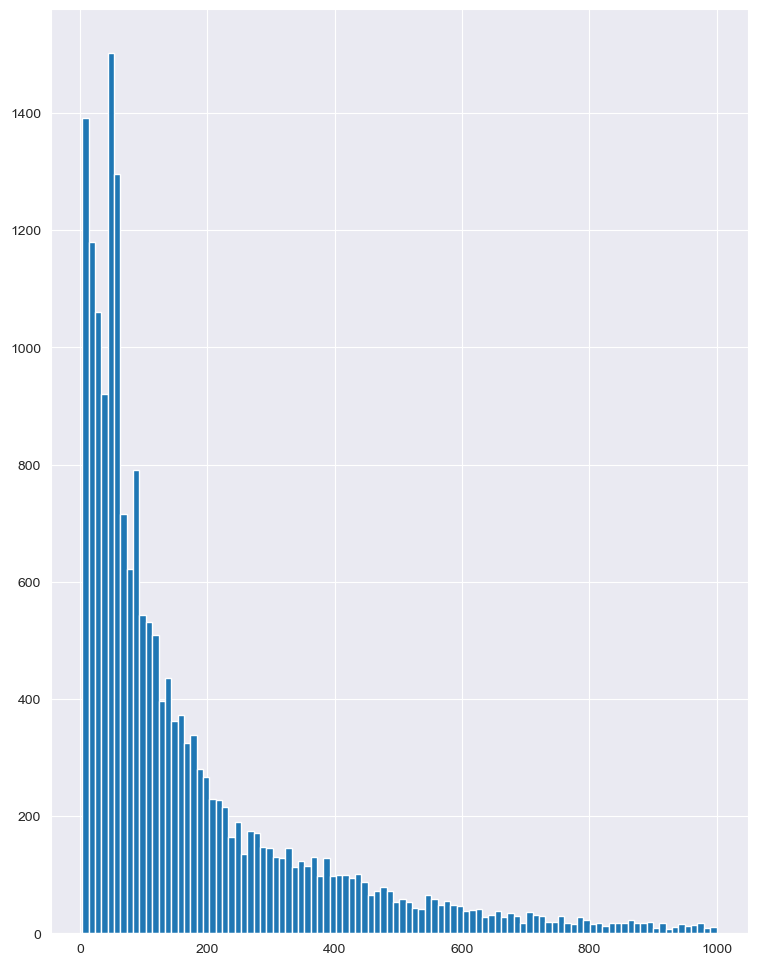

In [133]:
data['days_exposition'].hist(bins=100,figsize=(9,12));

count    19070.000000
mean       168.913634
std        187.886679
min          4.000000
25%         45.000000
50%         95.000000
75%        224.000000
max       1000.000000
Name: days_exposition, dtype: float64

Первый квартиль: 45.00000000000001
Третий квартиль: 224.0
Количество необычно долгих продаж: 4754
Количество быстрых продаж: 4682
2 наиболее часто встречающихся значения столбца "days_exposition": 45 и 60


<Axes: >

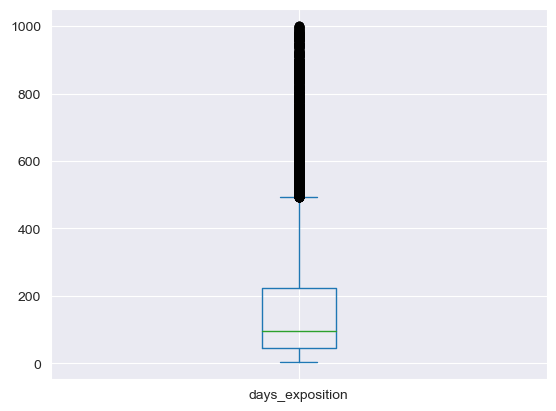

In [134]:
print(data['days_exposition'].describe())
print(f'\nПервый квартиль: {data["days_exposition"].quantile(0.25)}')
print(f'Третий квартиль: {data["days_exposition"].quantile(0.75)}')
print(f'Количество необычно долгих продаж: {len(data[data["days_exposition"] > data["days_exposition"].quantile(0.75)])}')
print(f'Количество быстрых продаж: {len(data[data["days_exposition"] < data["days_exposition"].quantile(0.25)])}')
print(f'2 наиболее часто встречающихся значения столбца "days_exposition": '
      f'{round(data["days_exposition"].value_counts().index[0])} и {round(data["days_exposition"].value_counts().index[1])}')
data['days_exposition'].plot(kind='box')

##### Cколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

Я считаю, что быстрые продажы – продажы за менее чем 45 дней (первый квартиль), а долгие продажи – продажы за более чем 224 дня (третий квартиль)

#### **Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

Коэффициент корреляции Пирсона для столбца "last_price" и для столбца с количественными данными "total_area":
0.7480497175968118
Коэффициент корреляции Пирсона для столбца "last_price" и для столбца с количественными данными "living_area":
0.6428976266150342
Коэффициент корреляции Пирсона для столбца "last_price" и для столбца с количественными данными "kitchen_area":
0.566982295532513
Коэффициент корреляции Пирсона для столбца "last_price" и для столбца с количественными данными "rooms":
0.4517833017261534
Коэффициент корреляции Пирсона для столбца "last_price" и для столбца с количественными данными "first_day_exposition_year":
-0.035498765304242244


                floor_type_int_count  last_price_median
floor_type_int                                         
0.0                             2703          3980000.0
1.0                            16277          4850000.0
2.0                             3093          4300000.0


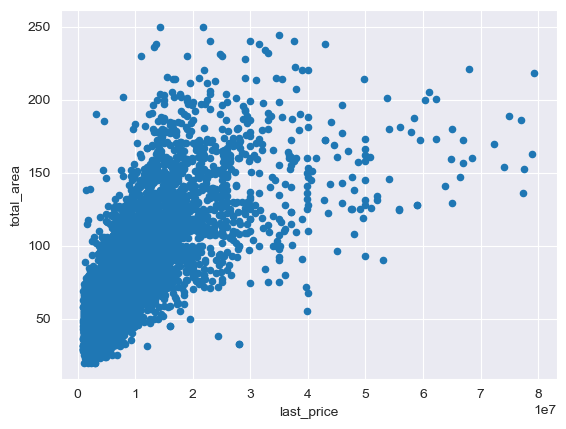

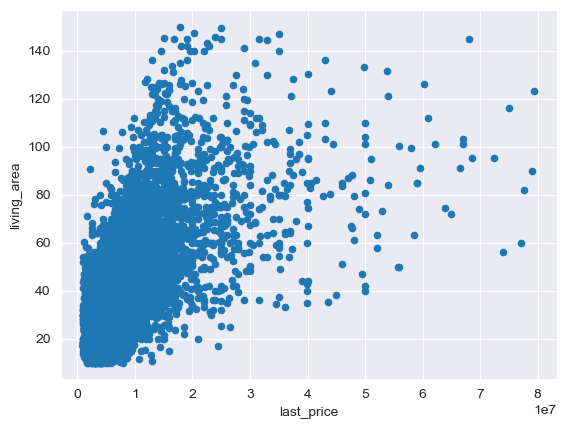

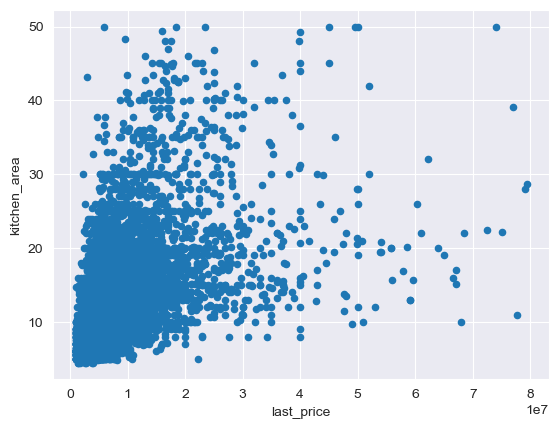

In [135]:
considered_column = 'last_price'
columns_list = ['total_area','living_area','kitchen_area','rooms','first_day_exposition_year','first_day_exposition_weekday',
                'first_day_exposition_month','floor_type']

for column in columns_list[:3]:
    print(f'Коэффициент корреляции Пирсона для столбца "last_price" и для столбца с количественными данными '
              f'"{column}":\n{data[column].corr(data[considered_column])}')
    data.loc[:,[considered_column,column]].plot(x=considered_column,y=column,kind='scatter')

for column in columns_list[3:5]:
    print(f'Коэффициент корреляции Пирсона для столбца "last_price" и для столбца с количественными данными '
              f'"{column}":\n{data[column].corr(data[considered_column])}')

column = 'floor_type'
new_data = (
    data
    .groupby(column+'_int')
    .agg({column+'_int':"count","last_price":"median"})
    .rename({column+'_int':column+"_int_count","last_price":"last_price_median"},axis=1)
)
print(f'\n\n{new_data}')

columns_iter = iter(columns_list[3:])

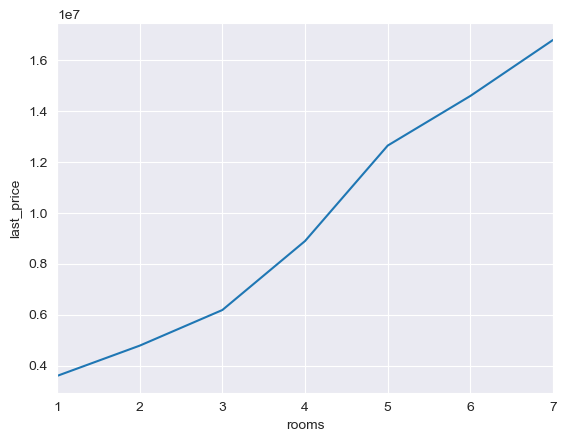

In [136]:
i = columns_iter.__next__()
grouped_table = (
    data
    .groupby(i)
    .agg({i:'count','last_price':'median'})
    .rename({i:i+'_count','last_price':i+'_price_median'},axis=1)
)
grouped_table[i+'_price_median'].plot(grid=True,xlim=(min(grouped_table.index),max(grouped_table.index)),ylabel='last_price');

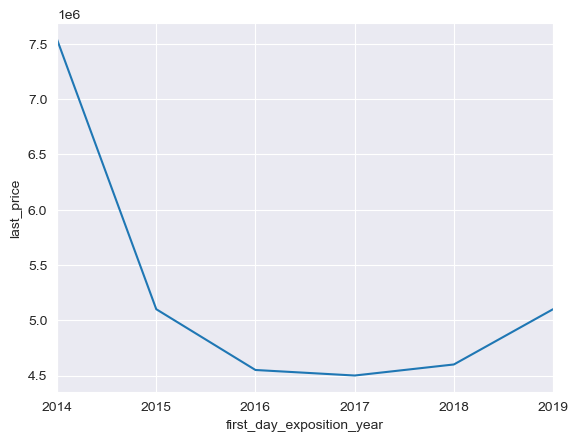

In [137]:
i = columns_iter.__next__()
grouped_table = (
    data
    .groupby(i)
    .agg({i:'count','last_price':'median'})
    .rename({i:i+'_count','last_price':i+'_price_median'},axis=1)
)
grouped_table[i+'_price_median'].plot(grid=True,xlim=(min(grouped_table.index),max(grouped_table.index)),ylabel='last_price');

**Построю линейный график зависимости года, в котором было выложено объявление, от медианной общей площади квартир за определенный год**

,total_area_median,first_day_exposition_year_price_median
first_day_exposition_year,,
2014.0,75.88,7540000.0
2015.0,58.60,5100000.0
2016.0,53.30,4550000.0
2017.0,52.00,4500000.0
2018.0,51.00,4600000.0
2019.0,52.00,5100000.0


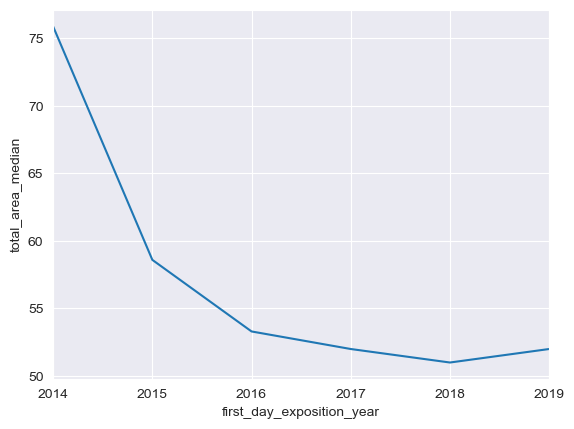

In [138]:
i='total_area'
column = 'first_day_exposition_year'
grouped_table = (
    data
    .groupby(column)
    .agg({i:'median','last_price':'median'})
    .rename({i:i+'_median','last_price':column+'_price_median'},axis=1)
)
display(grouped_table)
grouped_table[i+'_median'].plot(grid=True,xlim=(min(grouped_table.index),max(grouped_table.index)),ylabel=i+'_median');

**Построю линейный график зависимости года, в котором было выложено объявление, от количества объявлений о продаже за этот год**

2014.0      88
2015.0     943
2016.0    2631
2017.0    7688
2018.0    8003
2019.0    2720
Name: first_day_exposition_year, dtype: int64

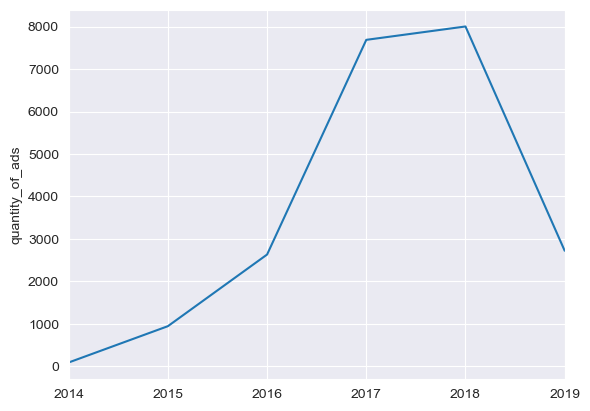

In [139]:
i='total_area'
column = 'first_day_exposition_year'
grouped_table = (
    data[column]
    .value_counts()
    .sort_index()
)
display(grouped_table)
grouped_table.plot(grid=True,xlim=(min(grouped_table.index),max(grouped_table.index)),ylabel='quantity_of_ads');

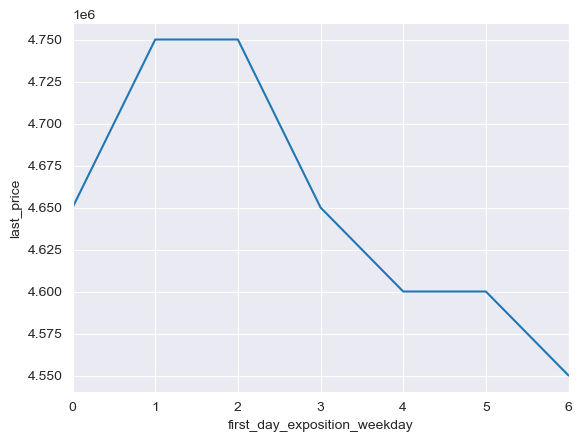

In [140]:
i = columns_iter.__next__()
grouped_table = (
    data
    .groupby(i)
    .agg({i:'count','last_price':'median'})
    .rename({i:i+'_count','last_price':i+'_price_median'},axis=1)
)
grouped_table[i+'_price_median'].plot(grid=True,xlim=(min(grouped_table.index),max(grouped_table.index)),ylabel='last_price');

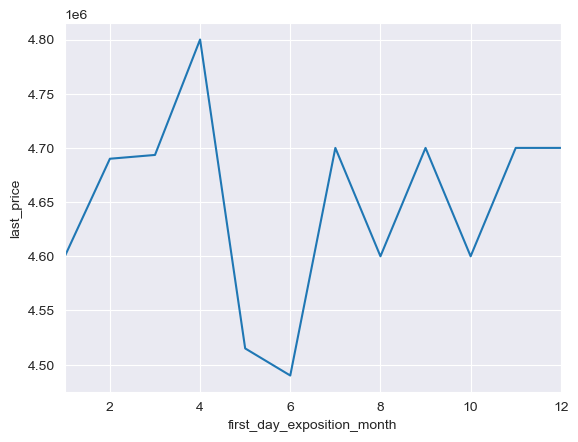

In [141]:
i = columns_iter.__next__()
grouped_table = (
    data
    .groupby(i)
    .agg({i:'count','last_price':'median'})
    .rename({i:i+'_count','last_price':i+'_price_median'},axis=1)
)
grouped_table[i+'_price_median'].plot(grid=True,xlim=(min(grouped_table.index),max(grouped_table.index)),ylabel='last_price');

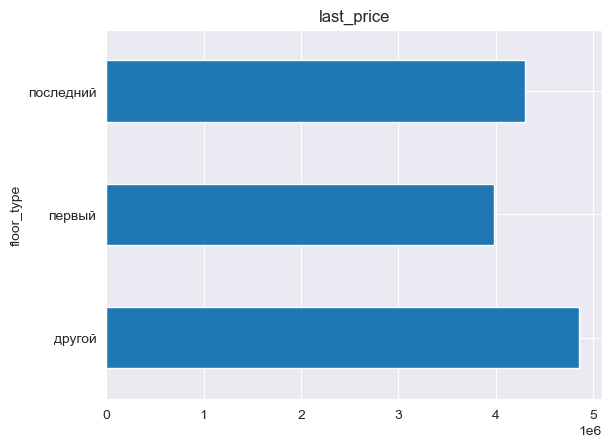

In [142]:
j = columns_iter.__next__()
i = j
grouped_table = (
    data
    .groupby(i)
    .agg({i:'count','last_price':'median'})
    .rename({i:i+'_count','last_price':i+'_price_median'},axis=1)
)
grouped_table[i+'_price_median'].plot.barh(title='last_price');

**Минивывод:**

На диаграммах рассеяния для столбцов с количественными данными можно заметить корреляцию, что подтверждают соответствующие коэффициенты корреляции Пирсона.

Итак, получаем положительную корреляцию цены квартиры с общей площадью, площадью кухни, жилой площадью и количеством комнат.

На линейной диаграмме зависимости года размещения объявления от цены квартиры можно заметить, что с 2014 по 2018 года медианная цена за квартиры снижалась, в 2019 году произошел небольшой прирост цены.

Очень похожая ситуация на линейной диаграмме зависимости года размещения объявления от общей площади квартиры, что неудивительно, ведь общая площадь и цена квартиры сильно коррелируют.

На линейной диаграмме зависимости года размещения объявления от количества объявлений за год можно заметить, что с 2014 по 2018 год количество объявлений стремительно росло, а в 2019 году их количество снизилось почти что втрое по сравнению с 2018 годом.


**Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.**

,locality_name_count,price_per_square_meter
locality_name,,
Санкт-Петербург,"14,790.00","112,576.42"
поселок Мурино,436.00,"85,085.93"
поселок Шушары,422.00,"78,474.01"
Всеволожск,386.00,"68,680.27"
Пушкин,354.00,"102,928.74"
Колпино,331.00,"75,351.43"
Гатчина,301.00,"68,935.78"
деревня Кудрово,276.00,"92,193.78"
Выборг,228.00,"58,723.71"


Населенный пункт с самой высокой средней стоимостью одного квадратного метра: Санкт-Петербург
Населенный пункт с самой низкой средней стоимостью одного квадратного метра: Выборг


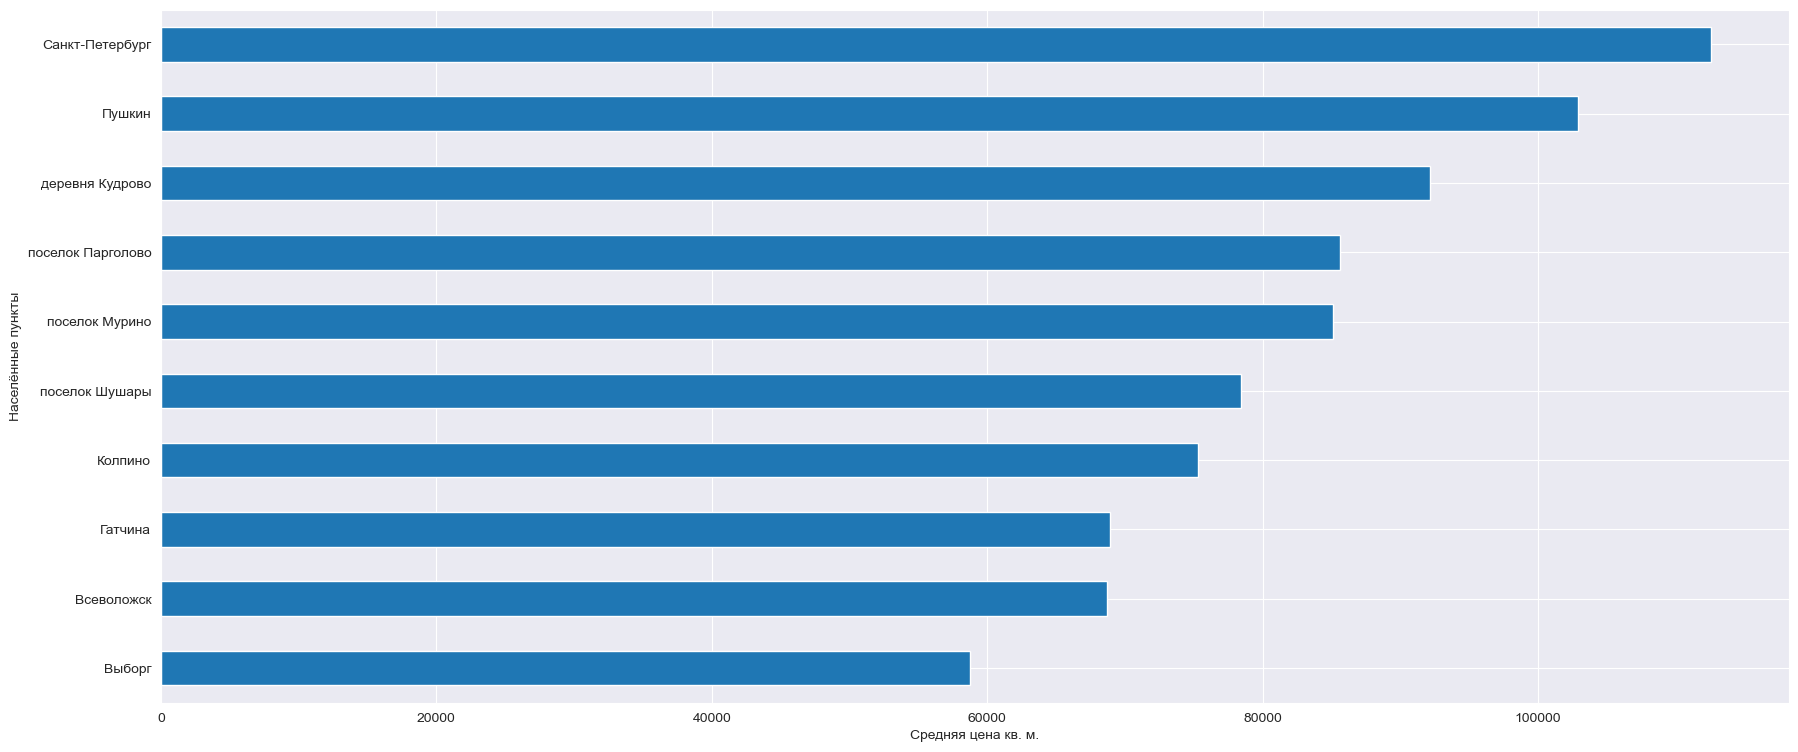

In [143]:
new_data = (
    data
    .groupby('locality_name')
    .agg({'locality_name':'count','price_per_square_meter':'mean'})
    .rename({'locality_name':'locality_name_count'},axis=1)
    .sort_values('locality_name_count',ascending = False)[0:10]
)
display(new_data.style.format("{:,.2f}"))
new_data.sort_values('price_per_square_meter',ascending = True)['price_per_square_meter'].plot.barh(figsize=(21,9),rot=0)
plt.ylabel('Населённые пункты')
plt.xlabel('Средняя цена кв. м.')
print(f'Населенный пункт с самой высокой средней стоимостью одного квадратного метра: '
      f'{new_data[new_data["price_per_square_meter"] == max(new_data["price_per_square_meter"])].index[0]}')
print(f'Населенный пункт с самой низкой средней стоимостью одного квадратного метра: '
      f'{new_data[new_data["price_per_square_meter"] == min(new_data["price_per_square_meter"])].index[0]}')

#### **Вычислю среднюю цену каждого километра в Санкт-Петербурге**

Количество квартир в Санкт-Петергбурге на расстоянии 27 км от центра: 2


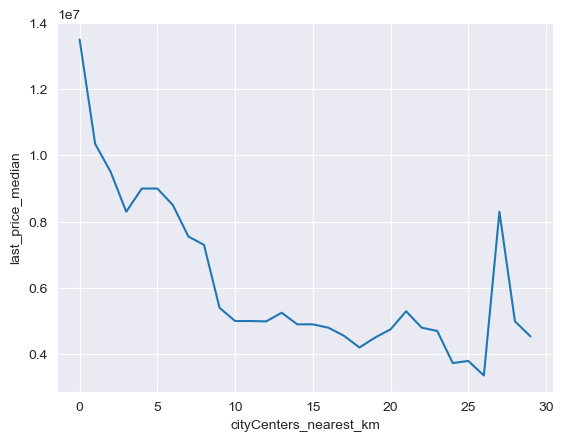

In [144]:
new_data = data[data['locality_name'] == 'Санкт-Петербург']
# print(new_data.columns)
# print(len(new_data))
new_data = new_data[~new_data['cityCenters_nearest_km'].isna()]
# print(new_data.info())
grouped_data = (
    new_data
    .groupby('cityCenters_nearest_km')
    .agg({'cityCenters_nearest_km':'count','last_price':'median'})
    .rename({'cityCenters_nearest_km':'cityCenters_nearest_km_count','last_price':'last_price_median'},axis=1)\
    ['last_price_median']
)
print(f'Количество квартир в Санкт-Петергбурге на расстоянии 27 км от центра: {new_data["cityCenters_nearest_km"].value_counts()[27]}')
grouped_data.plot(grid=True,ylabel='last_price_median');

При увеличении расстояния с 0 до 26 км от центра Санкт-Петербурга цена за квартиры постепенно снижается, затем наблюдается резкий пик "на 27-ом километре" (это связано с тем, что всего лишь 2 объявления о продаже квартир "на 27-ом километре"), далее закономерный спад

In [145]:
display(new_data.loc[new_data['cityCenters_nearest_km'] == 3,['rooms','last_price']].describe().style.format("{:,.2f}"))
display(new_data.loc[new_data['cityCenters_nearest_km'] == 5,['rooms','last_price']].describe().style.format("{:,.2f}"))
display(data['last_price'].describe())
print(f'\nДоля квартир на 3-ем километре: {len(new_data[new_data["cityCenters_nearest_km"] == 3])/len(new_data)}')
print(f'\nДоля квартир на 5-ем километре: {len(new_data[new_data["cityCenters_nearest_km"] == 5])/len(new_data)}')

,rooms,last_price
count,322.00,322.00
mean,2.91,"10,081,330.28"
std,1.27,"5,913,187.93"
min,1.00,"2,385,000.00"
25%,2.00,"6,312,500.00"
50%,3.00,"8,300,000.00"
75%,4.00,"12,000,000.00"
max,7.00,"48,000,000.00"


,rooms,last_price
count,819.00,819.00
mean,2.69,"11,609,232.53"
std,1.20,"7,794,403.03"
min,1.00,"1,800,000.00"
25%,2.00,"6,785,881.00"
50%,3.00,"9,000,000.00"
75%,3.00,"13,275,000.00"
max,7.00,"62,316,000.00"


count    2.207300e+04
mean     6.048378e+06
std      5.236350e+06
min      1.000000e+06
25%      3.490000e+06
50%      4.650000e+06
75%      6.750000e+06
max      7.933900e+07
Name: last_price, dtype: float64


Доля квартир на 3-ем километре: 0.021854214741414416

Доля квартир на 5-ем километре: 0.055585720103162754


In [146]:
# способы группировки и сортировки информации

(
   new_data
     .query('3 <= cityCenters_nearest_km <=5 ')
     .groupby(['cityCenters_nearest_km', 'floor_type'])['last_price']
     .agg(['count', 'mean'])
     .reset_index()
     .style.format("{:,.0f}", subset=['cityCenters_nearest_km', 'mean'])
)

,cityCenters_nearest_km,floor_type,count,mean
0,3,другой,196,"10,796,910"
1,3,первый,51,"7,484,704"
2,3,последний,75,"9,976,989"
3,4,другой,459,"11,520,031"
4,4,первый,74,"7,929,784"
5,4,последний,105,"11,237,201"
6,5,другой,622,"11,994,422"
7,5,первый,73,"7,593,849"
8,5,последний,124,"12,040,968"


### Общий вывод

Я исследовал архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

Список задач, которые я выполнил:

    1) Выполнил предобработку данных, а именно:
        * Обнаружил пропуски в столбцах таблицы и обработал их
        * Обнаружил столбцы, в которых следует изменить тип данных и преобразовал тип данных в этих столбцах
        * Обнаружил и  устранил неявные дубликаты
        * Обнаружил и устранил редкие и выбивающиеся значения (выбросы)
    
    2) Добавил в таблицы новые столбцы, необходимые для дальнейшего исследования
    
    3) Провёл исследовательский анализ данных, а именно:
        * Изучил некоторые столбцы и построил для них гистограммы
        * Изучил как быстро продавались квартиры
        * Понял, какие факторы больше всего влияют на общую стоимость общую (полную) стоимость квартиры
        * Посчитал среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
          Выделил населённые пункты с самой высокой и низкой стоимостью квадратного метра.
        * Выделил квартиры в Санкт-Петербурге и вычислил среднюю цену каждого километра.
          Описал, как стоимость объектов зависит от расстояния до центра города.

### Бонус

In [147]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

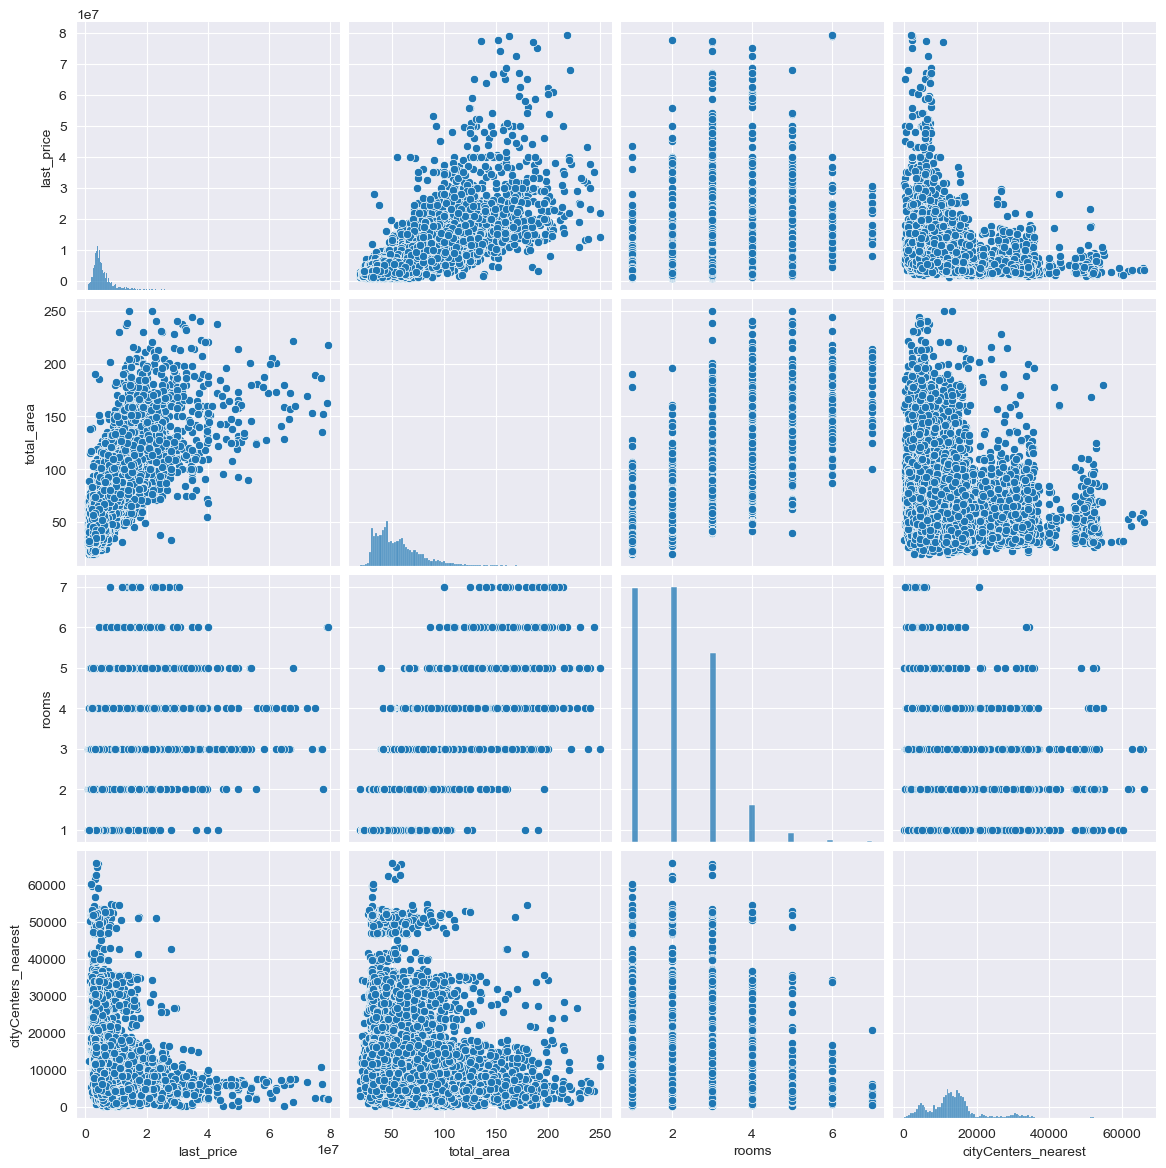

In [148]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


C:\Users\dmitr\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


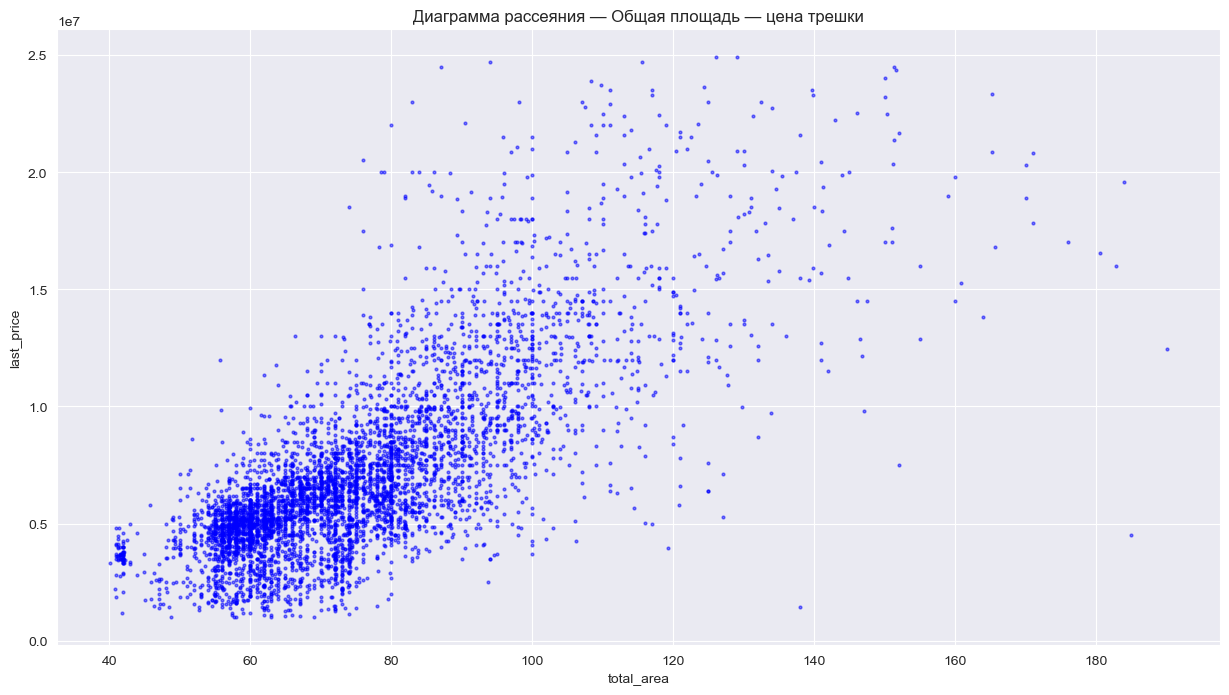

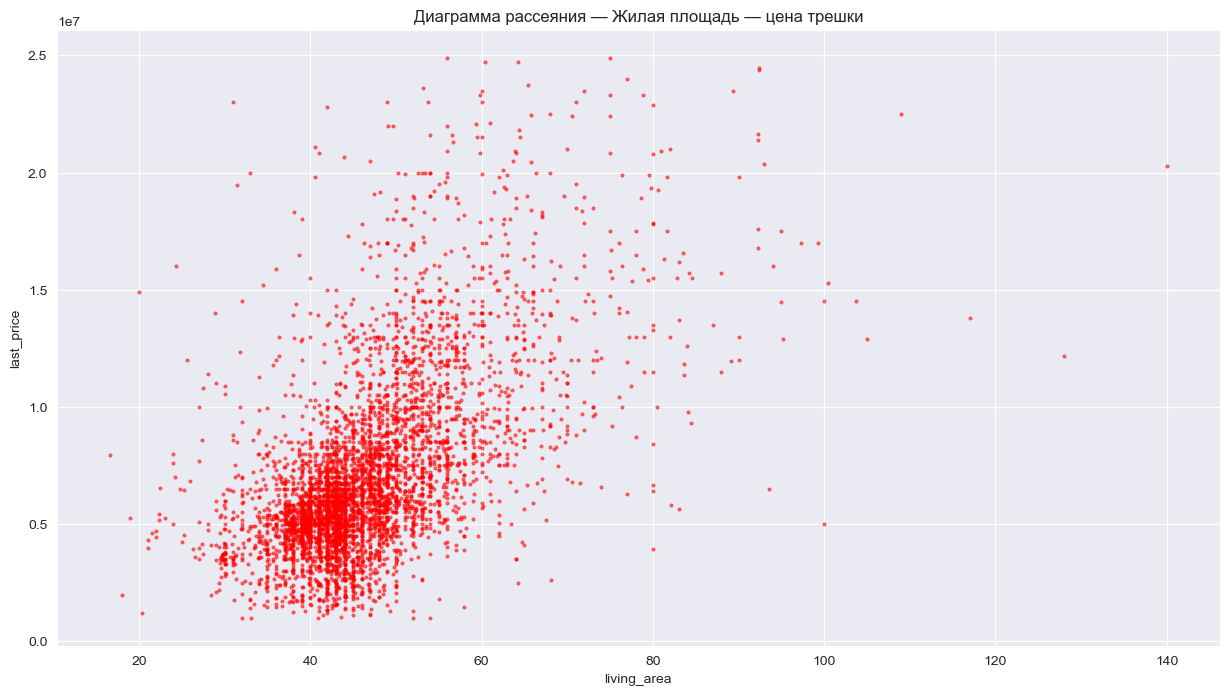

In [149]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

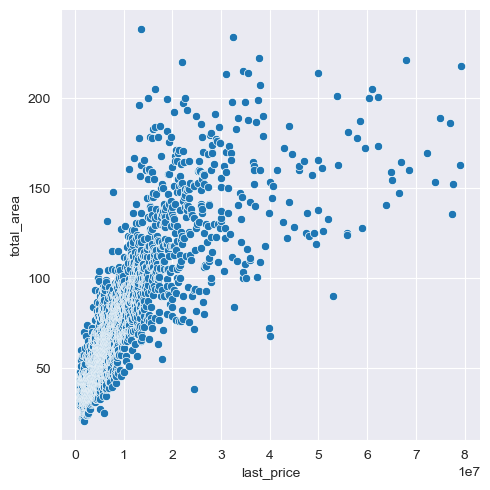

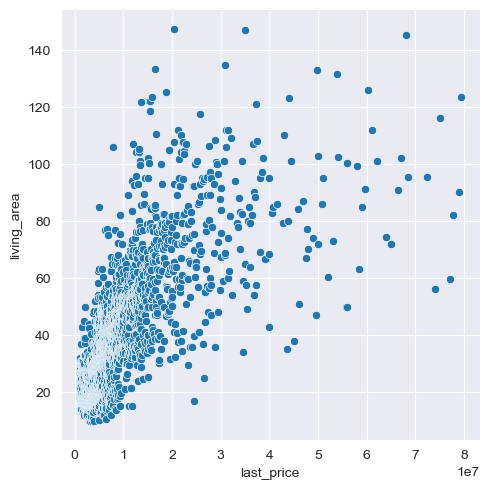

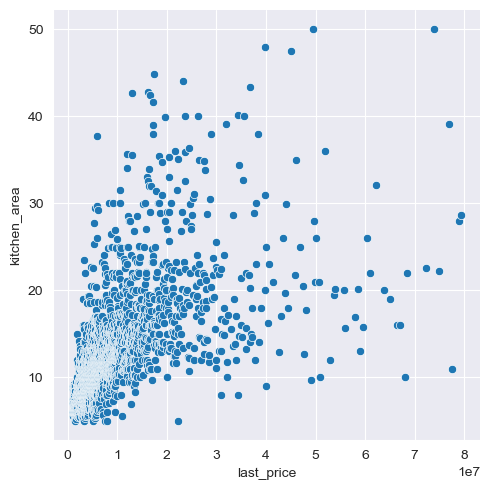

In [150]:
# check
price_pivot_area = data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')

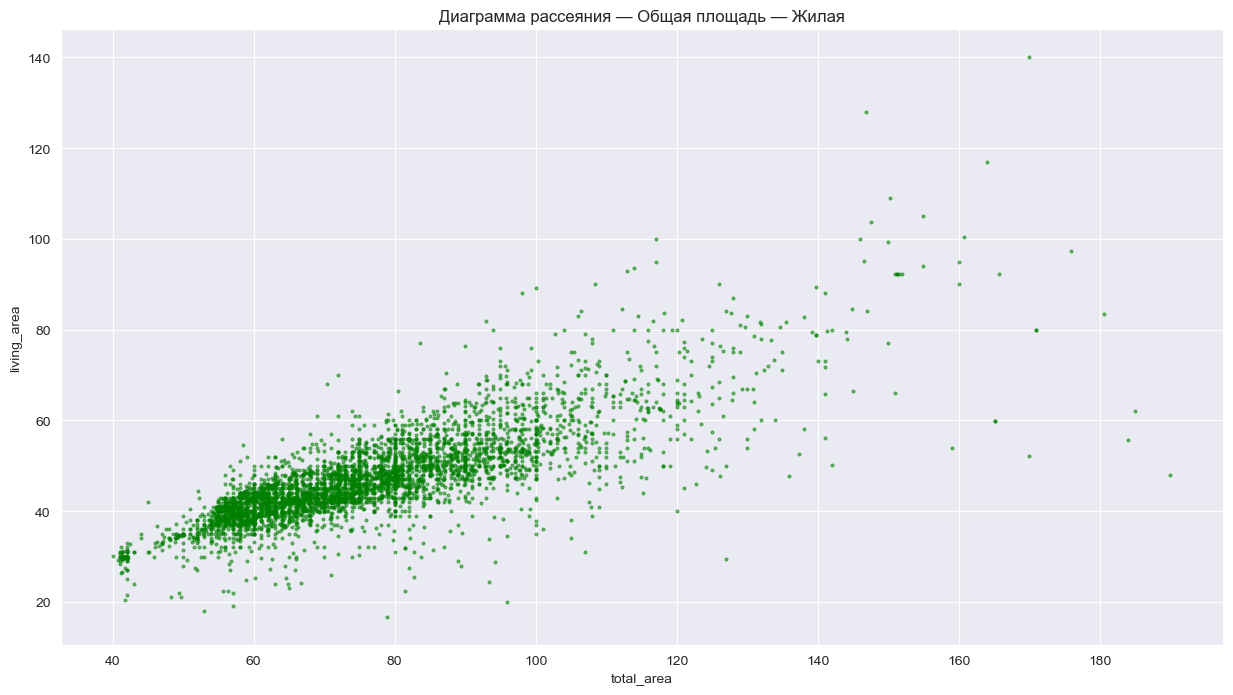

In [151]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

**Чек-лист готовности проекта**

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод